In [22]:
#import torch
import pandas as pd
import shapely
import numpy as np
import sys
#import torch
import argparse
import random
import math
import os
import warnings
from shapely.geometry import LineString, Polygon
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler# 好处在于可以保存训练集中的参数（均值、方差）
from scipy.stats import stats
#from torch.utils.data import DataLoader
#from torch.optim import lr_scheduler
import tqdm
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 999
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
import gc
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# calculate the right features of each polygon

In [68]:
polys = []
with open("../points.txt","r") as f:
    for li in f:
        polys.append(li[:-1])

In [69]:
polys = [i.split(";") for i in polys]
#polys = []

In [70]:
for poly in polys:
    poly[0] = " "+poly[0]

In [71]:
new_polys = []
for poly in polys:
    temp = []
    for index, coord in enumerate(poly):
        if index<len(poly)-1 and coord == poly[index+1]:
            continue
        else:
            temp.append(coord)
    new_polys.append(';'.join(temp))

0


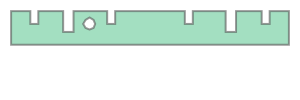

1


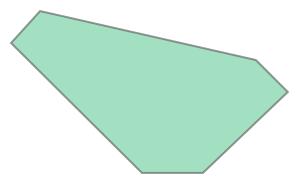

2


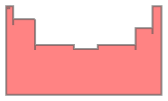

3


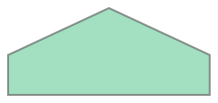

4


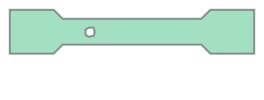

5


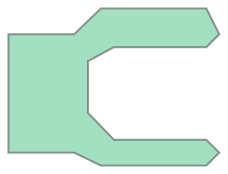

6


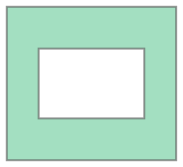

7


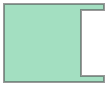

8


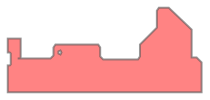

9


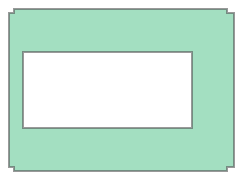

10


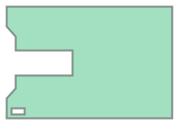

11


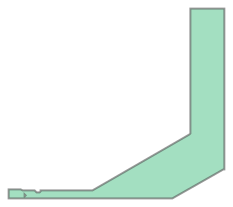

12


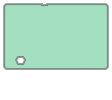

13


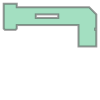

14


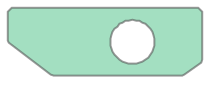

15


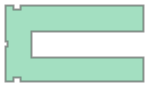

16


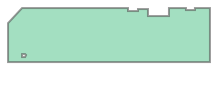

17


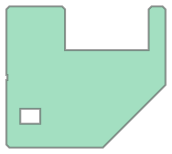

18


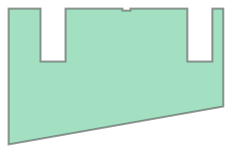

19


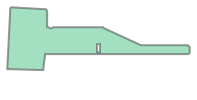

20


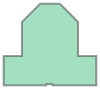

21


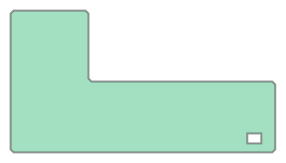

22


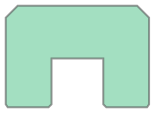

23


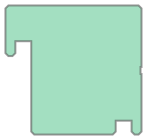

24


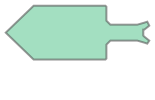

25


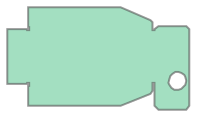

26


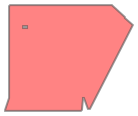

27


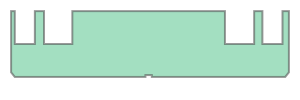

28


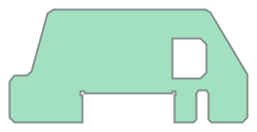

29


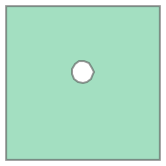

30


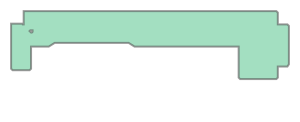

31


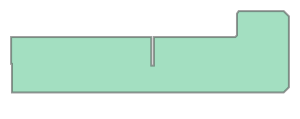

32


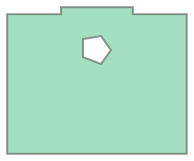

33


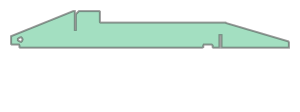

34


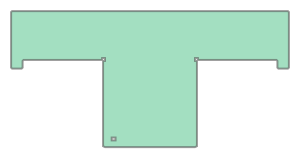

35


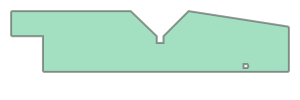

36


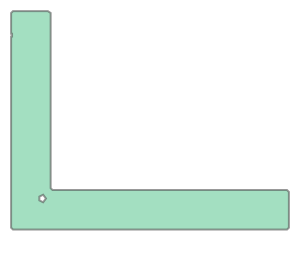

37


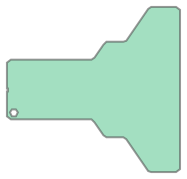

38


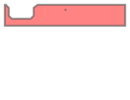

39


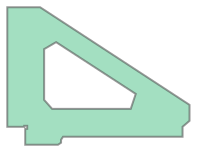

40


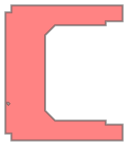

41


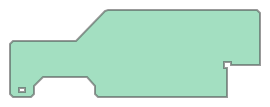

42


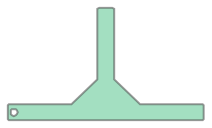

43


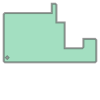

44


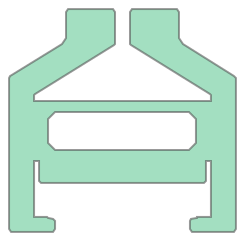

45


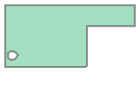

46


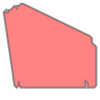

47


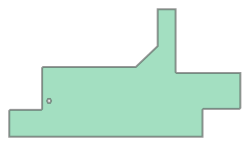

48


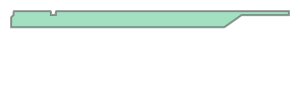

49


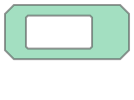

50


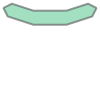

51


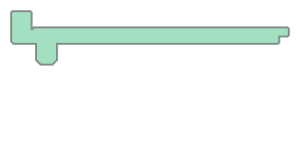

52


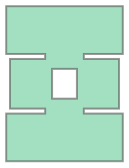

53


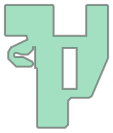

In [73]:
polygon_list = []

for index, poly in enumerate(new_polys):
    if "--" in poly:
        print(index)
        b = poly.split(";--;")
        vor = b[0]
        nach = b[1]

        b = vor.split(";")
        c = [l.strip() for l in b]
        x = [float(l.split(" ")[0]) for l in c ]
        y = [float(l.split(" ")[1]) for l in c ]
        xy = [(x[i], y[i]) for i in range(len(x))]

        b = nach.split(";")
        c = [l.strip() for l in b]
        x = [float(l.split(" ")[0]) for l in c ]
        y = [float(l.split(" ")[1]) for l in c ]
        xy1 = [(x[i], y[i]) for i in range(len(x))]


        polygon = Polygon(xy,[xy1])
        polygon
        polygon_list.append(polygon)
    else:
        print(index)
        b = poly.split(";")
        c = [l.strip() for l in b]
        x = [float(l.split(" ")[0]) for l in c ]
        y = [float(l.split(" ")[1]) for l in c ]
        xy = [(x[i], y[i]) for i in range(len(x))]
        polygon = Polygon(xy)
        polygon
        polygon_list.append(polygon)

# Version 1
Seq to seq model: target use the scores + high + use rate

In [109]:
# read file
#data = pd.read_pickle('../data/thread_0_0_999.pkl')
data = pd.read_pickle('../sample.tmp')

In [115]:
data_temp = pd.read_pickle('../sample3.tmp')

In [116]:
data = pd.concat([data,data_temp])

In [117]:
data.shape

(4000000, 13)

In [120]:
del data
gc.collect()

0

## prepare the data
what kinds of data do we need
- vector representation of the 'Teile' 
- vector representation of the rotation
- number of knote in the Teile
- normalized area of teile
- normalized circle of teile
- normlized area/circle of teile
- normalized left down of teile
- normalized right down of teile
- normalized area/circle after convexing
- normalized length/width
- normalized centroid x/width
- normalized centroid y/length

In [119]:
df = data.copy()
df.head()

Jobid    Rot                                List of Coordinates  \
0  792-0_10_0  90.00  [(159.0, 49.0), (167.0, 44.0), (168.0, 44.0), ...   
1  792-0_10_1   0.00  [(199.0, 158.0), (93.0, 158.0), (66.0, 132.0),...   
2  792-0_10_2  90.00  [(20.0, 138.0), (20.0, 138.0), (20.0, 138.0), ...   
3  792-0_10_3   0.00  [(150.0, 128.0), (149.0, 128.0), (149.0, 92.0)...   
4  792-0_10_4  90.00  [(199.0, 158.0), (93.0, 158.0), (66.0, 132.0),...   

                                     Shapely Polygon Metric1 Metric2 Metric3  \
0  POLYGON ((159 49, 167 44, 168 44, 308 44, 308 ...    1.00    1.00    1.00   
1  POLYGON ((199 158, 93 158, 66 132, 0 132, 0 13...    2.00    1.00   96.00   
2  POLYGON ((20 138, 20 138, 20 138, 19 138, 17 1...    3.00    1.00  311.00   
3  POLYGON ((150 128, 149 128, 149 92, 149 91, 12...    4.00    2.00  453.00   
4  POLYGON ((199 158, 93 158, 66 132, 0 132, 0 13...    5.00    6.00  678.00   

  Metric4      Area   Length       Left down      right down  score  
0    2.00 20543.000 1270.063     (93.0, 1.0)   (93.0, 377.0)  0.000  
1    4.00 18230.000  919.686   (213.0, 96.0)  (213.0, 254.0)  4.000  
2    4.00 12481.500 1028.849  (139.0, 311.0)  (139.0, 494.0)  4.000  
3    4.00 14654.000 1000.590  (234.0, 453.0)  (234.0, 581.0)  4.000  
4    2.00 18230.000  919.686  (164.0, 678.0)  (164.0, 890.0)  0.000

In [57]:
len(df.iloc[:1000].Area.unique())
# It contains all 54 figure, because there are 54 different area

54

In [94]:

def area_quote_calculation(x):
    bounds_x = x.bounds[2]
    bounds_y = x.bounds[3]
    return x.area/(bounds_x*bounds_y)

def convex_area_quote_calculation(polygon):
    convex_hull_x, convex_hull_y = [z.tolist() for z in polygon.convex_hull.exterior.coords.xy]
    convex_polygon = Polygon(zip(convex_hull_x,convex_hull_y))
    convex_area_quote = convex_polygon.area/(convex_polygon.bounds[2]*convex_polygon.bounds[3])
    convex_area = convex_polygon.area
    quote = polygon.area / convex_area
    return convex_area_quote, convex_area, quote

result = []
for polygon in polygon_list:
    temp=[]
    temp.append(polygon)
    temp.append(polygon.area)
    temp.append(polygon.length)
    temp.append(area_quote_calculation(polygon))
    convex_area_quote, convex_area, area_verhaltnis = convex_area_quote_calculation(polygon)
    temp.append(convex_area_quote)
    temp.append(convex_area)
    temp.append(area_verhaltnis)
    temp.append(polygon.centroid.x/polygon.bounds[2])
    temp.append(polygon.centroid.y/polygon.bounds[3])
    temp.append(polygon.bounds[2]/polygon.bounds[3])
    
    result.append(temp)

In [137]:
poly.exterior.coords

In [95]:
features  = pd.DataFrame(result,columns=["Shapely Polygon", "Area", "length", "area quote", 
                                         "convex area quote", "convex area", "area verhaltnis", 
                                         "centroid x/width", "centroid y/height","width/height" ] )

In [96]:
features["bounding box"] = features["Shapely Polygon"].map(lambda x : x.bounds)

In [97]:
features.head()

Shapely Polygon      Area   length  \
0  POLYGON ((0 0, 347 0, 347 42, 323 42, 323 26, ... 13108.000 1054.864   
1  POLYGON ((0 130, 29 162, 245 113, 277 81, 192 ... 25080.500  672.899   
2  POLYGON ((129 50, 92 50, 92 46, 68 46, 68 50, ...  9188.000  622.828   
3  POLYGON ((202 0, 0 0, 0 40, 101 87, 202 40, 20... 12827.000  504.800   
4  POLYGON ((201 0, 245 0, 245 44, 201 44, 192 35...  8048.000  623.507   

   area quote  convex area quote  convex area  area verhaltnis  \
0       0.899              1.000    14574.000            0.899   
1       0.559              0.559    25080.500            1.000   
2       0.662              1.000    13884.000            0.662   
3       0.730              0.730    12827.000            1.000   
4       0.747              1.000    10780.000            0.747   

   centroid x/width  centroid y/height  width/height              bounding box  
0             0.503              0.474         8.262   (0.0, 0.0, 347.0, 42.0)  
1             0.507              0.508         1.710  (0.0, 0.0, 277.0, 162.0)  
2             0.492              0.351         1.753   (0.0, 0.0, 156.0, 89.0)  
3             0.500              0.382         2.322   (0.0, 0.0, 202.0, 87.0)  
4             0.501              0.500         5.568   (0.0, 0.0, 245.0, 44.0)

# Make useful identifier

In [66]:
# filter out some false features. because of the inner contour

In [121]:
df["bounding box"] = df["Shapely Polygon"].map(lambda x : x.bounds)

In [126]:
#del df["Area"]
#del df["Length"]
del df["Shapely Polygon"]
df = pd.merge(df, features, how="left", on="bounding box")

In [127]:
gc.collect()

2007

In [130]:
df.head()

Jobid    Rot Metric1 Metric2 Metric3 Metric4       Left down  \
0  792-0_10_0  90.00    1.00    1.00    1.00    2.00     (93.0, 1.0)   
1  792-0_10_1   0.00    2.00    1.00   96.00    4.00   (213.0, 96.0)   
2  792-0_10_2  90.00    3.00    1.00  311.00    4.00  (139.0, 311.0)   
3  792-0_10_3   0.00    4.00    2.00  453.00    4.00  (234.0, 453.0)   
4  792-0_10_4  90.00    5.00    6.00  678.00    2.00  (164.0, 678.0)   

       right down  score              bounding box  \
0   (93.0, 377.0)  0.000   (0.0, 0.0, 376.0, 92.0)   
1  (213.0, 254.0)  4.000  (0.0, 0.0, 212.0, 158.0)   
2  (139.0, 494.0)  4.000  (0.0, 0.0, 183.0, 138.0)   
3  (234.0, 581.0)  4.000  (0.0, 0.0, 232.0, 128.0)   
4  (164.0, 890.0)  0.000  (0.0, 0.0, 212.0, 158.0)   

                                     Shapely Polygon      Area   length  \
0  POLYGON ((159 49, 167 44, 168 44, 308 44, 308 ... 20525.000 1008.101   
1  POLYGON ((199 158, 93 158, 66 132, 0 132, 0 13... 18230.000  919.686   
2  POLYGON ((20 138, 19 138, 17 138, 16 138, 0 13... 12481.500  839.767   
3  POLYGON ((150 128, 149 128, 149 92, 149 91, 12... 14630.000  716.843   
4  POLYGON ((199 158, 93 158, 66 132, 0 132, 0 13... 18230.000  919.686   

   area quote  convex area quote  convex area  area verhaltnis  \
0       0.593              0.932    32244.000            0.637   
1       0.544              0.938    31429.000            0.580   
2       0.494              0.678    17130.000            0.729   
3       0.493              0.708    21019.500            0.696   
4       0.544              0.938    31429.000            0.580   

   centroid x/width  centroid y/height  width/height  
0             0.540              0.658         4.087  
1             0.412              0.501         1.342  
2             0.394              0.416         1.326  
3             0.517              0.309         1.812  
4             0.412              0.501         1.342

In [131]:
del df["Metric4"]
del df["Metric3"]
del df["Metric2"]
del df["Metric1"]

In [132]:
gc.collect()

479

In [134]:
df.head()

Jobid    Rot       Left down      right down  score  \
0  792-0_10_0  90.00     (93.0, 1.0)   (93.0, 377.0)  0.000   
1  792-0_10_1   0.00   (213.0, 96.0)  (213.0, 254.0)  4.000   
2  792-0_10_2  90.00  (139.0, 311.0)  (139.0, 494.0)  4.000   
3  792-0_10_3   0.00  (234.0, 453.0)  (234.0, 581.0)  4.000   
4  792-0_10_4  90.00  (164.0, 678.0)  (164.0, 890.0)  0.000   

               bounding box  \
0   (0.0, 0.0, 376.0, 92.0)   
1  (0.0, 0.0, 212.0, 158.0)   
2  (0.0, 0.0, 183.0, 138.0)   
3  (0.0, 0.0, 232.0, 128.0)   
4  (0.0, 0.0, 212.0, 158.0)   

                                     Shapely Polygon      Area   length  \
0  POLYGON ((159 49, 167 44, 168 44, 308 44, 308 ... 20525.000 1008.101   
1  POLYGON ((199 158, 93 158, 66 132, 0 132, 0 13... 18230.000  919.686   
2  POLYGON ((20 138, 19 138, 17 138, 16 138, 0 13... 12481.500  839.767   
3  POLYGON ((150 128, 149 128, 149 92, 149 91, 12... 14630.000  716.843   
4  POLYGON ((199 158, 93 158, 66 132, 0 132, 0 13... 18230.000  919.686   

   area quote  convex area quote  convex area  area verhaltnis  \
0       0.593              0.932    32244.000            0.637   
1       0.544              0.938    31429.000            0.580   
2       0.494              0.678    17130.000            0.729   
3       0.493              0.708    21019.500            0.696   
4       0.544              0.938    31429.000            0.580   

   centroid x/width  centroid y/height  width/height  
0             0.540              0.658         4.087  
1             0.412              0.501         1.342  
2             0.394              0.416         1.326  
3             0.517              0.309         1.812  
4             0.412              0.501         1.342

In [139]:
# get num of corr

df['num_of_corr'] = df['Shapely Polygon'].map(lambda x: len(list(x.exterior.coords)))
#features["num_of_corr"] = features["Shapely Polygon"].map(lambda x:len(list(x.boundary.coords)))
#del features["Shapely Polygon"]

In [142]:
#df[3000000:].to_csv("feature2.csv")

In [34]:
data = pd.read_csv("feature.csv", index_col = [0])

In [5]:
temp = pd.read_csv("feature2.csv", index_col = [0])

In [6]:
data = pd.concat([data,temp])

In [7]:
#-------------------------------------------------------------------------------

In [35]:
data

Jobid    Rot         Left down        right down  score  \
0           792-0_10_0 90.000       (93.0, 1.0)     (93.0, 377.0)  0.000   
1           792-0_10_1  0.000     (213.0, 96.0)    (213.0, 254.0)  4.000   
2           792-0_10_2 90.000    (139.0, 311.0)    (139.0, 494.0)  4.000   
3           792-0_10_3  0.000    (234.0, 453.0)    (234.0, 581.0)  4.000   
4           792-0_10_4 90.000    (164.0, 678.0)    (164.0, 890.0)  0.000   
5           792-0_10_5 90.000    (156.0, 840.0)   (156.0, 1020.0)  0.000   
6           792-0_10_6  0.000    (727.0, 841.0)    (727.0, 911.0)  0.000   
7           792-0_10_7 90.000     (68.0, 990.0)    (68.0, 1066.0)  4.000   
8           792-0_10_8  0.000   (411.0, 1304.0)   (411.0, 1451.0)  0.000   
9           792-0_10_9 90.000   (389.0, 1015.0)   (389.0, 1280.0)  0.000   
10         792-0_10_10  0.000   (549.0, 1297.0)   (549.0, 1463.0)  0.000   
11         792-0_10_11  0.000   (392.0, 1161.0)   (392.0, 1182.0)  0.500   
12         792-0_10_12 90.000   (559.0, 1465.0)   (559.0, 1553.3)  4.000   
13         792-0_10_13 90.000   (315.0, 1167.0)   (315.0, 1288.0)  4.000   
14         792-0_10_14  0.000   (591.8, 1091.0)   (591.8, 1145.5)  0.500   
15         792-0_10_15 90.000   (346.0, 1192.0)   (346.0, 1271.0)  4.000   
16         792-0_10_16 90.000   (340.0, 1251.0)   (340.0, 1496.0)  0.000   
17         792-0_10_17  0.000    (277.0, 416.0)    (277.0, 505.0)  0.000   
18         792-0_10_18  0.000     (746.0, 97.0)    (746.0, 167.0)  4.000   
19         792-0_10_19  0.000    (415.0, 679.0)    (415.0, 817.0)  0.000   
20         792-0_10_20  0.000   (678.0, 1292.0)   (678.0, 1346.0)  0.500   
21         792-0_10_21  0.000    (350.0, 866.0)    (350.0, 916.0)  0.500   
22         792-0_10_22 90.000    (408.0, 897.0)   (408.0, 1080.0)  0.000   
23         792-0_10_23 90.000   (663.0, 1397.0)   (663.0, 1599.0)  0.000   
24         792-0_10_24 90.000   (902.3, 1349.0)   (902.3, 1452.6)  4.000   
25         792-0_10_25  0.000    (614.0, 643.0)    (614.0, 730.0)  4.000   
26         792-0_10_26 90.000   (630.0, 1226.0)   (630.0, 1423.0)  0.000   
27         792-0_10_27  0.000    (394.0, 271.0)    (394.0, 377.0)  4.000   
28         792-0_10_28 90.000    (420.0, 403.0)    (420.0, 557.0)  4.000   
29         792-0_10_29 90.000   (682.0, 1270.0)   (682.0, 1472.0)  0.000   
...                ...    ...               ...               ...    ...   
1499970  792-1904_4_38  0.000      (680.0, 1.0)    (680.0, 143.0)  4.000   
1499971  792-1904_4_39  0.000    (769.0, 270.0)    (769.0, 312.0)  0.500   
1499972  792-1904_4_40  0.000    (628.0, 270.0)    (628.0, 412.0)  4.000   
1499973  792-1904_4_41  0.000    (547.0, 417.0)    (547.0, 467.0)  0.500   
1499974  792-1904_4_42 90.000   (1833.3, 997.0)  (1833.3, 1100.6)  4.000   
1499975  792-1904_4_43  0.000  (1928.0, 1124.0)  (1928.0, 1282.0)  0.000   
1499976  792-1904_4_44 90.000  (1818.0, 1347.0)  (1818.0, 1491.0)  0.000   
1499977  792-1904_4_45 90.000  (1967.0, 1335.0)  (1967.0, 1463.0)  0.000   
1499978  792-1904_4_46  0.000      (935.0, 1.0)     (935.0, 95.0)  4.000   
1499979  792-1904_4_47  0.000    (736.0, 474.0)    (736.0, 528.0)  0.500   
1499980  792-1904_4_48  0.000    (694.6, 566.0)    (694.6, 689.3)  4.000   
1499981  792-1904_4_49 90.000    (878.0, 619.0)    (878.0, 835.0)  4.000   
1499982   792-1904_6_0  0.000      (203.0, 1.0)     (203.0, 55.0)  0.500   
1499983   792-1904_6_1 90.000     (65.0, 207.0)     (65.0, 337.0)  4.000   
1499984   792-1904_6_2 90.000    (103.0, 272.0)    (103.0, 416.0)  4.000   
1499985   792-1904_6_3 90.000    (191.0, 377.0)    (191.0, 593.0)  4.000   
1499986   792-1904_6_4  0.000    (171.0, 430.0)    (171.0, 584.0)  4.000   
1499987   792-1904_6_5 90.000    (142.0, 604.0)    (142.0, 819.0)  0.000   
1499988   792-1904_6_6 90.000    (107.0, 743.0)    (107.0, 871.0)  4.000   
1499989   792-1904_6_7 90.000     (55.5, 852.0)     (55.5, 976.8)  4.000   
1499990   792-1904_6_8  0.000    (125.8, 909.0)    (125.8, 963.5)

In [8]:
df = data.copy()

In [9]:
df.head()

Jobid    Rot       Left down      right down  score  \
0  792-0_10_0 90.000     (93.0, 1.0)   (93.0, 377.0)  0.000   
1  792-0_10_1  0.000   (213.0, 96.0)  (213.0, 254.0)  4.000   
2  792-0_10_2 90.000  (139.0, 311.0)  (139.0, 494.0)  4.000   
3  792-0_10_3  0.000  (234.0, 453.0)  (234.0, 581.0)  4.000   
4  792-0_10_4 90.000  (164.0, 678.0)  (164.0, 890.0)  0.000   

               bounding box  \
0   (0.0, 0.0, 376.0, 92.0)   
1  (0.0, 0.0, 212.0, 158.0)   
2  (0.0, 0.0, 183.0, 138.0)   
3  (0.0, 0.0, 232.0, 128.0)   
4  (0.0, 0.0, 212.0, 158.0)   

                                     Shapely Polygon      Area   length  \
0  POLYGON ((159 49, 167 44, 168 44, 308 44, 308 ... 20525.000 1008.101   
1  POLYGON ((199 158, 93 158, 66 132, 0 132, 0 13... 18230.000  919.686   
2  POLYGON ((20 138, 19 138, 17 138, 16 138, 0 13... 12481.500  839.767   
3  POLYGON ((150 128, 149 128, 149 92, 149 91, 12... 14630.000  716.843   
4  POLYGON ((199 158, 93 158, 66 132, 0 132, 0 13... 18230.000  919.686   

   area quote  convex area quote  convex area  area verhaltnis  \
0       0.593              0.932    32244.000            0.637   
1       0.544              0.938    31429.000            0.580   
2       0.494              0.678    17130.000            0.729   
3       0.493              0.708    21019.500            0.696   
4       0.544              0.938    31429.000            0.580   

   centroid x/width  centroid y/height  width/height  num_of_corr  
0             0.540              0.658         4.087           31  
1             0.412              0.501         1.342           17  
2             0.394              0.416         1.326           22  
3             0.517              0.309         1.812           26  
4             0.412              0.501         1.342           17

In [10]:
df.shape

(4000000, 17)

In [11]:
df["Jobid"] = df["Jobid"].astype(str)

In [12]:
def str_to_tuple(string):
    string = string[1:-1]
    string = string.split(",")
    string = [l.strip() for l in string]
    return (float(string[0]), float(string[1]))
df["Left down"] = df["Left down"].map(str_to_tuple)

In [13]:
df["right down"] = df["right down"].map(str_to_tuple)

In [14]:
df["bounding box"] = df["bounding box"].map(str_to_tuple)

In [15]:
#df.isnull().values.any()

In [16]:
# get onehot data for rotation
df['Rot'][df['Rot'] == 5.00] = 0.00
# get onehot data

In [17]:
ohe = OneHotEncoder()
tmp = ohe.fit_transform(df['Rot'].values.reshape(-1, 1)).toarray()
tmp = pd.DataFrame(tmp)
tmp.columns = ['r1', 'r2']
df = pd.concat([df, tmp], axis = 1)

In [18]:
del tmp
gc.collect()

0

In [19]:
# al = area /length
df['A/L'] = df['Area']/df['length']

In [20]:
# get coordinate of echo value
df['Left_down_x'] = df['Left down'].map(lambda x: x[0])
df['Left_down_y'] = df['Left down'].map(lambda x: x[1])
df['Right_down_y'] = df['right down'].map(lambda x: x[1])

In [21]:
df.columns

Index(['Jobid', 'Rot', 'Left down', 'right down', 'score', 'bounding box',
       'Shapely Polygon', 'Area', 'length', 'area quote', 'convex area quote',
       'convex area', 'area verhaltnis', 'centroid x/width',
       'centroid y/height', 'width/height', 'num_of_corr', 'r1', 'r2', 'A/L',
       'Left_down_x', 'Left_down_y', 'Right_down_y'],
      dtype='object')

In [23]:
# normalize the area, Length, num_of_corr, Left_down_x, Left_down_y, Right_down_y, A/L ...
scaler_area = MinMaxScaler().fit(df['Area'].values.reshape(-1, 1))
scaler_length = MinMaxScaler().fit(df['length'].values.reshape(-1, 1))
scaler_num_of_corr = MinMaxScaler().fit(df['num_of_corr'].values.reshape(-1, 1))
scaler_al = MinMaxScaler().fit(df['A/L'].values.reshape(-1, 1))

scaler_area_quote = MinMaxScaler().fit(df['area quote'].values.reshape(-1, 1))
scaler_convex_area_quote = MinMaxScaler().fit(df['convex area quote'].values.reshape(-1, 1))
scaler_centroid_x_width = MinMaxScaler().fit(df['centroid x/width'].values.reshape(-1, 1))
scaler_centroid_y_height = MinMaxScaler().fit(df['centroid y/height'].values.reshape(-1, 1))
scaler_widt_height = MinMaxScaler().fit(df['width/height'].values.reshape(-1, 1))
scaler_convex_area = MinMaxScaler().fit(df['convex area'].values.reshape(-1, 1))
scaler_area_verhaltnis = MinMaxScaler().fit(df['area verhaltnis'].values.reshape(-1, 1))

scaler_ldx = StandardScaler().fit(df['Left_down_x'].values.reshape(-1, 1))
scaler_ldy = StandardScaler().fit(df['Left_down_y'].values.reshape(-1, 1))
scaler_rdy = StandardScaler().fit(df['Right_down_y'].values.reshape(-1, 1))

In [24]:
df['norm_area'] = scaler_area.transform(df['Area'].values.reshape(-1, 1))
df['length'] = scaler_length.transform(df['length'].values.reshape(-1, 1))
df['num_of_corr'] = scaler_num_of_corr.transform(df['num_of_corr'].values.reshape(-1, 1))
df['A/L'] = scaler_al.transform(df['A/L'].values.reshape(-1, 1))

df['area quote'] = scaler_area_quote.transform(df['area quote'].values.reshape(-1, 1))
df['convex area quote'] = scaler_convex_area_quote.transform(df['convex area quote'].values.reshape(-1, 1))
df['centroid x/width'] = scaler_centroid_x_width.transform(df['centroid x/width'].values.reshape(-1, 1))
df['centroid y/height'] = scaler_centroid_y_height.transform(df['centroid y/height'].values.reshape(-1, 1))
df['width/height'] = scaler_widt_height.transform(df['width/height'].values.reshape(-1, 1))
df['convex area'] = scaler_convex_area.transform(df['convex area'].values.reshape(-1, 1))
df['area verhaltnis'] = scaler_area_verhaltnis.transform(df['area verhaltnis'].values.reshape(-1, 1))

df['norm_left_down_x'] = scaler_ldx.transform(df['Left_down_x'].values.reshape(-1, 1))
df['norm_left_down_y'] = scaler_ldy.transform(df['Left_down_y'].values.reshape(-1, 1))
df['norm_right_down_y'] = scaler_rdy.transform(df['Right_down_y'].values.reshape(-1, 1))

In [25]:
df.to_pickle("all_norm_feature.pkl")

In [33]:
df['Jobid']

0            792-0_10
1            792-0_10
2            792-0_10
3            792-0_10
4            792-0_10
5            792-0_10
6            792-0_10
7            792-0_10
8            792-0_10
9            792-0_10
10           792-0_10
11           792-0_10
12           792-0_10
13           792-0_10
14           792-0_10
15           792-0_10
16           792-0_10
17           792-0_10
18           792-0_10
19           792-0_10
20           792-0_10
21           792-0_10
22           792-0_10
23           792-0_10
24           792-0_10
25           792-0_10
26           792-0_10
27           792-0_10
28           792-0_10
29           792-0_10
              ...    
3999970     792-847_1
3999971     792-847_1
3999972     792-847_1
3999973     792-847_1
3999974    792-847_20
3999975    792-847_20
3999976    792-847_20
3999977    792-847_20
3999978    792-847_20
3999979    792-847_20
3999980    792-847_20
3999981    792-847_20
3999982    792-847_20
3999983    792-847_20
3999984   

In [32]:
# combine the sequence in one task and transform to numpy
df['Jobid'] = df['Jobid'].map(lambda x: x.split('_')[0]+'_'+x.split('_')[1])

result = []
for name, group in tqdm.tqdm(df.groupby('Jobid')):
    if len(group) == 50:
        temp_x = group[['norm_area', 'length', 'num_of_corr', 'A/L', 
                        'area quote', 'convex area quote', 'centroid x/width',
                        'centroid y/height', 'width/height', 'convex area','area verhaltnis',
                        'r1', 'r2']]#.values.reshape(1, -1)
    
        #print(temp_x.shape)
        temp_result = []
        for i in range(50):
            group
            sub_group = group.iloc[:i+1, :]
            mean = sub_group["score"].mean()
            max_x = np.max(sub_group["Left_down_x"].values)
            norm_max_x = np.max(sub_group["norm_left_down_x"].values)
            max_y = np.max(sub_group["Right_down_y"].values)

            area_quote = 1-sub_group["Area"].sum()/(max_x*max_y)
            temp_result.append(mean+area_quote+0.5*norm_max_x)
        break
        #print(len(temp_result))
        #print(temp_x.shape)
        result.append(pd.DataFrame(np.concatenate((temp_x.values.reshape(1, -1),np.array(temp_result).reshape(1,-1)),axis=1), index = [name]))

  0%|                                                                                        | 0/80017 [00:00<?, ?it/s]

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

In [27]:
Dataframe = pd.concat(result)

In [31]:
Dataframe.to_pickle("Dataframe_feature.pkl")

In [29]:
Dataframe.shape

(79626, 700)

In [ ]:
#1000000

In [31]:
#df.head()

Jobid    Rot                                List of Coordinates  \
0  92600-1250_7   0.00  [(0.0, 9.0), (9.0, 0.0), (115.8, 0.0), (124.8,...   
1  92600-1250_7  90.00  [(0.0, 9.0), (9.0, 0.0), (115.8, 0.0), (124.8,...   
2  92600-1250_7  90.00  [(1.0, 123.3), (0.0, 122.3), (0.0, 93.3), (1.0...   
3  92600-1250_7  90.00  [(6.0, 38.0), (7.1, 40.0), (97.5, 40.0), (98.7...   
4  92600-1250_7  90.00  [(28.5, 0.0), (60.1, 0.0), (84.4, 7.9), (88.3,...   

                                     Shapely Polygon Metric1  Metric2  \
0  POLYGON ((0 9, 9 0, 115.8 0, 124.8 9, 124.8 45...   17.00  132.000   
1  POLYGON ((0 9, 9 0, 115.8 0, 124.8 9, 124.8 45...   18.00  288.000   
2  POLYGON ((1 123.3, 0 122.3, 0 93.3, 1 92.3, 21...   19.00  386.000   
3  POLYGON ((6 38, 7.1 40, 97.5 40, 98.7 38, 98.7...   20.00  135.000   
4  POLYGON ((28.5 0, 60.1 0, 84.40000000000001 7....   21.00  491.000   

   Metric3  Metric4      Area   Length        Left down  score  \
0  849.000    5.000  4439.800  615.763   (256.8, 849.0)  0.500   
1 1354.000    4.000  4439.800  615.763  (342.5, 1354.0)  4.000   
2 1352.000    4.000  7228.382  901.580  (509.3, 1352.0)  4.000   
3 1186.000    2.000 23178.165 1448.933  (175.0, 1186.0)  0.000   
4 1466.000    4.000  1103.760  192.719  (511.0, 1466.0)  4.000   

        right down  num_of_corr  area quote  convex area quote  \
0   (256.8, 903.5)           19       0.653              0.976   
1  (342.5, 1478.8)           19       0.653              0.976   
2  (509.3, 1455.6)           55       0.566              0.801   
3  (175.0, 1874.3)           17       0.842              0.910   
4  (511.0, 1554.3)           13       0.625              0.819   

   centroid x/width  centroid y/height  width/height    s1    s2    s3    s4  \
0             0.532              0.500         2.290 0.000 0.000 1.000 0.000   
1             0.532              0.500         2.290 0.000 0.000 1.000 0.000   
2             0.517              0.580         0.840 0.000 0.000 0.000 0.000   
3             0.432              0.523        17.207 0.000 1.000 0.000 0.000   
4             0.501              0.457         4.415 1.000 0.000 0.000 0.000   

     s5    s6    r1    r2    A/L  Left_down_x  Left_down_y  Right_down_y  \
0 0.000 0.000 1.000 0.000  7.210      256.800      849.000       903.500   
1 0.000 0.000 0.000 1.000  7.210      342.500     1354.000      1478.800   
2 0.000 1.000 0.000 1.000  8.017      509.300     1352.000      1455.600   
3 0.000 0.000 0.000 1.000 15.997      175.000     1186.000      1874.300   
4 0.000 0.000 0.000 1.000  5.727      511.000     1466.000      1554.300   

   norm_area  norm_length  norm_num_of_corr  norm_A/L  norm_area quote  \
0     -0.920       -0.761            -0.482    -0.921           -0.018   
1     -0.920       -0.761            -0.482    -0.921           -0.018   
2     -0.618       -0.124             2.119    -0.747           -0.502   
3      1.110        1.097            -0.627     0.976            1.037   
4     -1.281       -1.705            -0.916    -1.241           -0.173   

   norm_convex area quote  norm_centroid x/width  norm_centroid y/height  \
0                   0.989                  1.181                  -0.418   
1                   0.989                  1.181                  -0.418   
2                  -0.516                  0.784                   1.699   
3                   0.420                 -1.398                   0.180   
4                  -0.361                  0.393                  -1.568   

   norm_width/height  norm_left_down_x  norm_left_down_y  norm_right_down_y  
0             -0.499            -0.897            -0.119             -0.343  
1             -0.499            -0.744             0.947              0.703  
2             -0.755            -0.447             0.943              0.661  
3              2.136            -1.042             0.592              1.423  
4             -0.124            -0.444             1.184              0.841

13771800

20000.0

In [25]:
Dataframe.to_csv("features_50labels.csv")

(50, 17)

0.03091740608215332


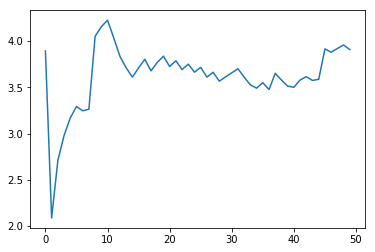

In [119]:
# for test
temp_x = group[['norm_area', 'norm_length', 'norm_num_of_corr', 'norm_A/L', 
                'norm_area quote', 'norm_convex area quote', 'norm_centroid x/width',
                'norm_centroid y/height', 'norm_width/height',
                's1', 's2', 's3', 's4', 's5', 's6', 'r1', 'r2']]#.values.reshape(1, -1)
x = []
temp_result = []
for i in range(50):
    sub_group = group.iloc[:i+1, :]
    mean = sub_group["score"].mean()
    max_x = np.max(sub_group["Left_down_x"].values)
    norm_max_x = np.max(sub_group["norm_left_down_x"].values)
    max_y = np.max(sub_group["Right_down_y"].values)

    area_quote = 1-sub_group["Area"].sum()/(max_x*max_y)
    temp_result.append(mean+area_quote+0.5*norm_max_x)
    x.append(mean+area_quote+0.5*norm_max_x)
plt.plot(x)
plt.show()

In [105]:
# read tmp result
result = pd.read_csv('../results/features_50labels.csv', index_col = 0)

In [106]:
result.head()

0      1      2      3      4      5      6      7      8  \
92600-1005_1   1.328  1.064 -0.193  1.315 -1.690 -1.739 -1.323  0.530  0.013   
92600-1005_10 -1.281 -1.705 -0.916 -1.241 -0.173 -0.361  0.393 -1.568 -0.124   
92600-1005_13  0.377  0.421  0.096  0.615  1.337  1.194  0.358 -0.429 -0.771   
92600-1005_14  1.328  1.064 -0.193  1.315 -1.690 -1.739 -1.323  0.530  0.013   
92600-1005_15 -0.920 -0.761 -0.482 -0.921 -0.018  0.989  1.181 -0.418 -0.499   

                  9    10    11    12    13    14    15    16     17     18  \
92600-1005_1  0.000 0.000 0.000 1.000 0.000 0.000 0.000 1.000 -1.281 -1.705   
92600-1005_10 1.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000  0.377  0.421   
92600-1005_13 0.000 0.000 0.000 0.000 1.000 0.000 0.000 1.000  1.328  1.064   
92600-1005_14 0.000 0.000 0.000 1.000 0.000 0.000 0.000 1.000 -0.618 -0.124   
92600-1005_15 0.000 0.000 1.000 0.000 0.000 0.000 1.000 0.000  1.110  1.097   

                  19     20     21     22     23     24     25    26    27  \
92600-1005_1  -0.916 -1.241 -0.173 -0.361  0.393 -1.568 -0.124 1.000 0.000   
92600-1005_10  0.096  0.615  1.337  1.194  0.358 -0.429 -0.771 0.000 0.000   
92600-1005_13 -0.193  1.315 -1.690 -1.739 -1.323  0.530  0.013 0.000 0.000   
92600-1005_14  2.119 -0.747 -0.502 -0.516  0.784  1.699 -0.755 0.000 0.000   
92600-1005_15 -0.627  0.976  1.037  0.420 -1.398  0.180  2.136 0.000 1.000   

                 28    29    30    31    32    33     34     35     36     37  \
92600-1005_1  0.000 0.000 0.000 0.000 0.000 1.000  0.377  0.421  0.096  0.615   
92600-1005_10 0.000 0.000 1.000 0.000 0.000 1.000  0.377  0.421  0.096  0.615   
92600-1005_13 0.000 1.000 0.000 0.000 1.000 0.000  1.328  1.064 -0.193  1.315   
92600-1005_14 0.000 0.000 0.000 1.000 1.000 0.000 -0.920 -0.761 -0.482 -0.921   
92600-1005_15 0.000 0.000 0.000 0.000 0.000 1.000 -0.618 -0.124  2.119 -0.747   

                  38     39     40     41     42    43    44    45    46  \
92600-1005_1   1.337  1.194  0.358 -0.429 -0.771 0.000 0.000 0.000 0.000   
92600-1005_10  1.337  1.194  0.358 -0.429 -0.771 0.000 0.000 0.000 0.000   
92600-1005_13 -1.690 -1.739 -1.323  0.530  0.013 0.000 0.000 0.000 1.000   
92600-1005_14 -0.018  0.989  1.181 -0.418 -0.499 0.000 0.000 1.000 0.000   
92600-1005_15 -0.502 -0.516  0.784  1.699 -0.755 0.000 0.000 0.000 0.000   

                 47    48    49    50     51     52     53     54     55  \
92600-1005_1  1.000 0.000 0.000 1.000 -0.920 -0.761 -0.482 -0.921 -0.018   
92600-1005_10 1.000 0.000 0.000 1.000 -0.618 -0.124  2.119 -0.747 -0.502   
92600-1005_13 0.000 0.000 0.000 1.000  1.110  1.097 -0.627  0.976  1.037   
92600-1005_14 0.000 0.000 0.000 1.000  1.110  1.097 -0.627  0.976  1.037   
92600-1005_15 0.000 1.000 1.000 0.000 -0.920 -0.761 -0.482 -0.921 -0.018   

                  56     57     58     59    60    61    62    63    64    65  \
92600-1005_1   0.989  1.181 -0.418 -0.499 0.000 0.000 1.000 0.000 0.000 0.000   
92600-1005_10 -0.516  0.784  1.699 -0.755 0.000 0.000 0.000 0.000 0.000 1.000   
92600-1005_13  0.420 -1.398  0.180  2.136 0.000 1.000 0.000 0.000 0.000 0.000   
92600-1005_14  0.420 -1.398  0.180  2.136 0.000 1.000 0.000 0.000 0.000 0.000   
92600-1005_15  0.989  1.181 -0.418 -0.499 0.000 0.000 1.000 0.000 0.000 0.000   

                 66    67     68     69     70     71     72     73    74  \
92600-1005_1  0.000 1.000 -1.281 -1.705 -0.916 -1.241 -0.173 -0.361 0.393   
92600-1005_10 0.000 1.000  0.377  0.421  0.096  0.615  1.337  1.194 0.358   
92600-1005_13 0.000 1.000 -0.920 -0.761 -0.482 -0.921 -0.018  0.989 1.181   
92600-1005_14 0.000 1.000  0.377  0.421  0.096  0.615  1.337  1.194 0.358   
92600-1005_15 0.000 1.000 -0.920 -0.761 -0.482 -0.921 -0.018  0.989 1.181   

                  75     76    77    78    79    80    81    82    83    84  \
92600-1005_1  -1.568 -0.124 1.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000   
92600-1005_10 -0.429 -0.771 0.000 0.000 0.000 0.000 1.000 0.000 0.000 1.000   
92600-

In [110]:
train_x = result.iloc[:int(len(result)*0.9), :850].values.reshape(int(len(result)*0.9), 50, -1)
test_x = result.iloc[int(len(result)*0.9):, :850].values.reshape(len(result) - int(len(result)*0.9), 50, -1)

In [113]:
train_y = result.iloc[:int(len(result)*0.9), 850:].values.reshape(int(len(result)*0.9), 50, -1)
test_y = result.iloc[int(len(result)*0.9):, 850:].values.reshape(len(result) - int(len(result)*0.9), 50, -1)

In [115]:
# save to the local system
np.save('../data/rnn_train_x', train_x)
np.save('../data/rnn_train_y', train_y)
np.save('../data/rnn_test_x', test_x)
np.save('../data/rnn_test_y', test_y)

'../data/rnn_train_x.npy'

## bild the rnn model

In [139]:
"""
bild the model, loss and data class, including two different versions
version 1:
seq to seq model
versioin 2:
seq to 1 model
"""
class TS_rnn(torch.nn.Module):
    """
    scores for each piece
    input:
        tensor size of (batch_size, seq_len, num_dim)
    output:
        tensor size of (batch_size, seq_len)
    """
    def __init__(self):
        super(TS_rnn, self).__init__()
        #change the structure of the network
        num_inp = 17
        num_hidden = 64
        self.rnn = torch.nn.LSTM(input_size = num_inp, hidden_size = num_hidden, num_layers = 2)
        self.mlp = torch.nn.Sequential(
                torch.nn.Linear(num_hidden, 16),
                torch.nn.Dropout(),
                torch.nn.ReLU(),
                torch.nn.Linear(16, 1)
                )

    def forward(self, inp):
        # input of the rnn (seq_len, batch, input_size)
        data_in = torch.transpose(inp, 0, 1)
        # run rnn, it has two output
        out_rnn, _ = self.rnn(data_in)
        out_rnn = torch.transpose(out_rnn, 0, 1) # (batch_size, seq_len, num_dim)
        # rnn the mlp
        batch_size, seq_len, num_dim = out_rnn.shape
        out = []
        for i in range(seq_len):
            tmp = self.mlp(out_rnn[:, i,:])
            out.append(tmp)
        # now out is list of (batch_size, 1), combine the items in the list to get the output with size (batch_size, seq_len)
        out = torch.cat(out, 1)
        #return out.squeeze() when the batch_size == 1, this can course trouble
        return out

class TS_rnn2(torch.nn.Module):
    """
    scores only for the whole task
    input:
        tensor size of (batch_size, seq_len, num_dim)
    output:
        tensor size of (batch_size)
    """
    def __init__(self):
        super(TS_rnn2, self).__init__()
        #change the structure of the network
        num_inp = 8
        num_hidden = 64
        self.rnn = torch.nn.LSTM(input_size = num_inp, hidden_size = num_hidden, num_layers = 2)
        self.mlp = torch.nn.Sequential(
                torch.nn.Linear(num_hidden, 64),
                torch.nn.Dropout(),
                torch.nn.ReLU(),
                torch.nn.Linear(64, 1)
                )

    def forward(self, inp):
        # input of the rnn (seq_len, batch, input_size)
        data_in = torch.transpose(inp, 0, 1)
        # run rnn, it has two output
        out_rnn, _ = self.rnn(data_in)
        out_rnn = torch.transpose(out_rnn, 0, 1) # (batch_size, seq_len, num_dim)
        # only use the last output
        out_rnn = out_rnn[:, -1, :].squeeze()
        # rnn the mlp
        out = self.mlp(out_rnn)
        return out.squeeze()
    
class PDLoss(torch.nn.Module):
    def __init__(self, p = 2):
        super(PDLoss, self).__init__()
        self.pd = torch.nn.PairwiseDistance(p)

    def forward(self, o, t):
        # out: (batch_size, 1)
        out = self.pd(o, t)
        return out.mean()

class Data:
    """
    data class for TS_rnn
    """
    def __init__(self, x, y):
        self.data = {}
        self.data['train_x'] = self.add_file(x).float()
        self.data['train_y'] = self.add_file(y)[:, :, -1].float() # use the first metric tempately
        assert(len(self.data['train_x']) == len(self.data['train_y']))
        self.len = len(self.data['train_x'])

    def add_file(self, path):
        return torch.from_numpy(np.load(path))

    def add_scores(self, path):
        return torch.FloatTensor([float(li.rstrip('\n')) for li in open(path)])

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return (self.data['train_x'][index],
                self.data['train_y'][index])

class Data2:
    """
    data class for TS_rnn2
    """
    def __init__(self, x, y):
        self.data = {}
        self.data['train_x'] = self.add_file(x)
        self.data['train_y'] = self.add_file(y)[:, :, -1] # use the first metric tempately
        self.data['train_y'] = torch.mean(self.data['train_y'], 1)
        assert(len(self.data['train_x']) == len(self.data['train_y']))
        self.len = len(self.data['train_x'])

    def add_file(self, path):
        return torch.from_numpy(np.load(path))

    def add_scores(self, path):
        return torch.FloatTensor([float(li.rstrip('\n')) for li in open(path)])

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return (self.data['train_x'][index],
                self.data['train_y'][index])

In [146]:
# write the test function
def test_model(dl_test, model, loss):
    model.eval()
    test_loss = 0
    counter = 0
    for batch_idx, dat in enumerate(dl_test):
        counter += 1
        # codes to be changed
        inp, target = dat
        out = model(inp)
        lo = loss(out, target)
        test_loss += lo.data
    return test_loss/counter

def significant_test(dl_test, model, loss):
    model.eval()
    test_loss = 0
    counter = 0
    hit = 0
    miss = 0
    for batch_idx, dat in enumerate(dl_test):
        counter += 1
        # codes to be changed
        inp, target = dat
        out = model(inp)
        target = target.mean(dim = 1)
        #print(out.shape)
        out = out.mean(dim = 1)
        #print(out.shape)
        if len(inp) > 5:
            _, top_target = torch.topk(target, 1)
            _, top_predict = torch.topk(out, 5)
            if top_target in top_predict:
                hit += 1
            else:
                miss += 1
    return hit * 1.0/(hit + miss)

In [147]:
# run the model
train_x = '../data/rnn_train_x.npy'
train_y = '../data/rnn_train_y.npy'
test_x = '../data/rnn_test_x.npy'
test_y = '../data/rnn_test_y.npy'
num_epochs = 100
batch_size = 30
verbose = True
# set models and loss
model = TS_rnn()
#loss = PDLoss()
loss = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
# set the scheduler
lamb1 = lambda x: .1**(x//30)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda = lamb1)
# loda data
train = Data(train_x, train_y)
test = Data(test_x, test_y)
dl_train = DataLoader(train, batch_size = batch_size, shuffle = True)
dl_test = DataLoader(test, batch_size = batch_size, shuffle = True)
# train the model
for epoch in range(num_epochs):
    scheduler.step()
    model.train()
    train_loss = 0
    counter = 0
    for batch_idx, dat in enumerate(dl_train):
        counter += 1
        # train the model
        optimizer.zero_grad()
        inp, target = dat
        out = model(inp)
        lo = loss(out, target)
        lo.backward()
        optimizer.step()
        train_loss += lo.data
        if verbose:
            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch,
                    batch_idx * batch_size,
                    len(train),
                    100.*batch_idx*batch_size/len(train),
                    lo.data
                    ))
    test_lo = test_model(dl_test, model, loss)
    hit_rate = significant_test(dl_test, model, loss)
    if verbose:
        # train loss
        print('====> Epoch: {} Average train loss: {:.4f}'.format(
            epoch,
            train_loss/counter
            ))
        # test loss
        print('====> Epoch: {} Average test loss: {:.4f}'.format(
            epoch,
            test_lo
            ))
        # significant test
        print('====> Epoch: {} Average hit rate in 10 candidate: {: .4f}'.format(
            epoch,
            hit_rate
        ))

Train Epoch: 0 [0/13771 (0%)]	Loss: 2.945713
Train Epoch: 0 [300/13771 (2%)]	Loss: 2.735838
Train Epoch: 0 [600/13771 (4%)]	Loss: 2.193754
Train Epoch: 0 [900/13771 (7%)]	Loss: 1.234544
Train Epoch: 0 [1200/13771 (9%)]	Loss: 1.194532
Train Epoch: 0 [1500/13771 (11%)]	Loss: 1.161489
Train Epoch: 0 [1800/13771 (13%)]	Loss: 1.063485
Train Epoch: 0 [2100/13771 (15%)]	Loss: 1.093979
Train Epoch: 0 [2400/13771 (17%)]	Loss: 1.097558
Train Epoch: 0 [2700/13771 (20%)]	Loss: 1.098471
Train Epoch: 0 [3000/13771 (22%)]	Loss: 1.077084
Train Epoch: 0 [3300/13771 (24%)]	Loss: 1.087945
Train Epoch: 0 [3600/13771 (26%)]	Loss: 1.090444
Train Epoch: 0 [3900/13771 (28%)]	Loss: 1.047425
Train Epoch: 0 [4200/13771 (30%)]	Loss: 1.112752
Train Epoch: 0 [4500/13771 (33%)]	Loss: 1.090375
Train Epoch: 0 [4800/13771 (35%)]	Loss: 1.051500
Train Epoch: 0 [5100/13771 (37%)]	Loss: 1.038006
Train Epoch: 0 [5400/13771 (39%)]	Loss: 1.051139
Train Epoch: 0 [5700/13771 (41%)]	Loss: 1.057357
Train Epoch: 0 [6000/13771 (44%

KeyboardInterrupt: 

In [39]:
# save model
torch.save(model, '../models/rnn_predict.pkl')

/anaconda3/envs/data_mining/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type TS_rnn. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
#?? how to get the weight of a mlp model in pytorch

In [157]:
mod = torch.nn.LSTM(input_size = 17, hidden_size = 64, num_layers = 3, dropout = 0.5)

In [173]:
parms = model.mlp.

In [176]:
parms.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [68]:
c = np.load('../data/rnn_train_y.npy')
c = torch.from_numpy(c)

In [181]:
a = torch.FloatTensor([3,2,3,2])
b = torch.FloatTensor([3,2,4,5])

In [190]:
c = torch.stack([a, b], dim = 0)

In [193]:
torch.std(c, dim = 1)

tensor([0.5774, 1.2910])

In [198]:
lamb1 = lambda x: 0.01 * 0.1**((x%100)//30)

In [206]:
lamb1(122)

0.01

In [205]:
pdist = torch.nn.PairwiseDistance(p=2)

In [206]:
a1 = torch.randn(4, 2)
a2 = torch.randn(4,2)

In [251]:
torch.mean(a1, 1)

tensor([-0.0431,  0.7919,  1.5557,  0.3310])

In [252]:
a1

tensor([[ 0.5227, -0.6088],
        [ 0.5556,  1.0283],
        [ 1.5431,  1.5683],
        [ 0.5531,  0.1089]])

In [211]:
a

tensor([1.6103, 2.5548, 3.8726, 3.3924])

In [8]:
a = ([0,0],[1,0],[1,0],[1,1],[1,1], [0,1],[0,0],[0.25,0.25], [0.25,0.75],[0.25,0.75],[0.75,0.75],[0.75,0.75],[0.75,0.25],[0.25,0.25])
Polygon(a).area

0.75

In [11]:
len(list(Polygon(a).boundary.coords))

15

In [12]:
len(a)

14

In [34]:
df['Metric2'].value_counts()

1.0       176215
2.0        38878
3.0        21295
83.0       20960
43.0       13990
158.0      13009
84.0       10989
125.0      10989
167.0       9990
217.0       7992
663.0       7992
622.0       7992
408.0       6993
240.0       6016
137.0       5995
561.0       5994
443.0       5994
124.0       5994
57.0        5994
279.0       5994
647.0       5994
165.0       5975
160.0       5372
94.0        5028
774.0       5017
249.0       4995
745.0       4995
692.0       4995
138.0       4995
119.0       4983
           ...  
80.0           4
1666.0         4
923.0          4
1226.0         4
1678.0         4
1139.0         4
873.0          4
163.0          4
1051.0         4
726.0          4
90.0           2
427.0          1
154.0          1
415.0          1
251.0          1
210.0          1
278.0          1
1638.0         1
495.0          1
1595.0         1
1592.0         1
1575.0         1
799.0          1
967.0          1
825.0          1
845.0          1
879.0          1
333.0         

In [ ]:
#
area_quote_6 = polygon6.area/(polygon6.bounds[2]*polygon6.bounds[3])
#
convex_hull_x, convex_hull_y = [z.tolist() for z in polygon6.convex_hull.exterior.coords.xy]
convex_polygon6 = Polygon(zip(convex_hull_x,convex_hull_y))
convex_area_quote_6 = convex_polygon6.area/(convex_polygon6.bounds[2]*convex_polygon6.bounds[3])
# 
print("the area use quote is : " , area_quote_6)
print("the area use quote of convex is : " , convex_area_quote_6)
print("the number of ecke :" , len(polygon6.boundary.coords))
print(polygon6.centroid)


area_quote_5 = polygon5.area/(polygon5.bounds[2]*polygon5.bounds[3])

convex_hull_x, convex_hull_y = [z.tolist() for z in polygon5.convex_hull.exterior.coords.xy]
convex_polygon5 = Polygon(zip(convex_hull_x,convex_hull_y))
convex_area_quote_5 = convex_polygon5.area/(convex_polygon5.bounds[2]*convex_polygon5.bounds[3])

print("the area use quote is : " , area_quote_5)
print("the area use quote of convex is : " , convex_area_quote_5)
print("the number of ecke :" , len(polygon5.boundary.coords))


area_quote_4 = polygon4.area/(polygon4.bounds[2]*polygon4.bounds[3])

convex_hull_x, convex_hull_y = [z.tolist() for z in polygon4.convex_hull.exterior.coords.xy]
convex_polygon4 = Polygon(zip(convex_hull_x,convex_hull_y))
convex_area_quote_4 = convex_polygon4.area/(convex_polygon4.bounds[2]*convex_polygon4.bounds[3])

print("the area use quote is : " , area_quote_4)
print("the area use quote of convex is : " , convex_area_quote_4)
print("the number of ecke :" , len(polygon4.boundary.coords))

area_quote_3 = polygon3.area/(polygon3.bounds[2]*polygon3.bounds[3])

convex_hull_x, convex_hull_y = [z.tolist() for z in polygon3.convex_hull.exterior.coords.xy]
convex_polygon3 = Polygon(zip(convex_hull_x,convex_hull_y))
convex_area_quote_3 = convex_polygon3.area/(convex_polygon3.bounds[2]*convex_polygon3.bounds[3])


print("the area use quote is : " , area_quote_3)
print("the area use quote of convex is : " , convex_area_quote_3)
print("the number of ecke :" , len(polygon3.boundary.coords))

area_quote_2 = polygon2.area/(polygon2.bounds[2]*polygon2.bounds[3])

convex_hull_x, convex_hull_y = [z.tolist() for z in polygon2.convex_hull.exterior.coords.xy]
convex_polygon2 = Polygon(zip(convex_hull_x,convex_hull_y))
convex_area_quote_2 = convex_polygon2.area/(convex_polygon2.bounds[2]*convex_polygon2.bounds[3])


print("the area use quote is : " , area_quote_2)
print("the area use quote of convex is : " , convex_area_quote_2)
print("the number of ecke :" , len(polygon2.boundary.coords))


area_quote_1 = polygon1.area/(polygon1.bounds[2]*polygon1.bounds[3])

convex_hull_x, convex_hull_y = [z.tolist() for z in polygon1.convex_hull.exterior.coords.xy]
convex_polygon1 = Polygon(zip(convex_hull_x,convex_hull_y))
convex_area_quote_1 = convex_polygon1.area/(convex_polygon1.bounds[2]*convex_polygon1.bounds[3])


print("the area use quote is : " , area_quote_1)
print("the area use quote of convex is : " , convex_area_quote_1)


a = [[polygon6, area_quote_6, convex_area_quote_6, polygon6.centroid.x, polygon6.centroid.y, convex_polygon6.bounds[2]/convex_polygon6.bounds[3]],
    [polygon5, area_quote_5, convex_area_quote_5, polygon5.centroid.x, polygon5.centroid.y, convex_polygon5.bounds[2]/convex_polygon5.bounds[3]],
    [polygon4, area_quote_4, convex_area_quote_4, polygon4.centroid.x, polygon4.centroid.y, convex_polygon4.bounds[2]/convex_polygon4.bounds[3]],
    [polygon3, area_quote_3, convex_area_quote_3, polygon3.centroid.x, polygon3.centroid.y, convex_polygon3.bounds[2]/convex_polygon3.bounds[3]],
    [polygon6, area_quote_2, convex_area_quote_2, polygon2.centroid.x, polygon2.centroid.y, convex_polygon2.bounds[2]/convex_polygon2.bounds[3]],
    [polygon6, area_quote_1, convex_area_quote_1, polygon1.centroid.x, polygon1.centroid.y, convex_polygon1.bounds[2]/convex_polygon1.bounds[3]]]



In [ ]:
[0 0; 347 0; 347 42; 323 42; 323 26; 313 26; 313 42; 281 42; 281 16; 268 16; 268 42; 227 42; 227 26; 217 26; 217 42; 130 42; 130 26; 120 26; 120 42; 78 42; 78 16; 65 16; 65 42; 34 42; 34 26; 24 26; 24 42; 0 42; 0 0;--; 105 26; 103 31; 98 34; 93 31; 90 26; 93 21; 98 19; 103 21; 105 26]


In [79]:
neu_figure = "[ 0 0; 347 0; 347 42; 323 42; 323 26; 313 26; 313 42; 281 42; 281 16; 268 16; 268 42; 227 42; 227 26; 217 26; 217 42; 130 42; 130 26; 120 26; 120 42; 78 42; 78 16; 65 16; 65 42; 34 42; 34 26; 24 26; 24 42; 0 42; 0 0; 105 26; 103 31; 98 34; 93 31; 90 26; 93 21; 98 19; 103 21; 105 26][ 0 130; 29 162; 245 113; 277 81; 192 0; 131 0; 0 130][ 129 50; 92 50; 92 46; 68 46; 68 50; 29 50; 29 50; 29 45; 29 45; 29 75; 28 76; 7 76; 7 75; 7 70; 7 70; 7 89; 6 89; 0 89; 0 89; 0 0; 0 0; 156 0; 156 0; 156 89; 156 89; 148 89; 147 89; 147 84; 147 84; 147 61; 147 61; 147 67; 130 67; 130 45; 130 45; 130 50; 129 50; 3 87; 3 88; 2 87; 3 87; 3 87][ 202 0; 0 0; 0 40; 101 87; 202 40; 202 0; 34 27; 34 27; 202 0][ 201 0; 245 0; 245 44; 201 44; 192 35; 53 35; 44 44; 0 44; 0 0; 44 0; 53 9; 192 9; 201 0; 85 22; 84 26; 79 26; 76 24; 76 19; 79 17; 84 18; 85 21; 85 22][ 199 158; 93 158; 66 132; 0 132; 0 13; 66 13; 93 0; 199 0; 212 13; 199 26; 106 26; 80 53; 80 105; 106 119; 199 119; 212 132; 199 158][ 170 154; 0 154; 0 154; 0 0; 0 0; 170 0; 170 0; 170 154; 170 154; 32 42; 32 112; 138 112; 138 42; 32 42][ 0 0; 100 0; 100 0; 100 6; 100 6; 77 6; 77 72; 100 72; 100 72; 100 78; 100 78; 0 78; 0 78; 0 0; 0 0][ 10 34; 43 34; 46 37; 46 45; 48 48; 91 48; 93 45; 93 36; 96 33; 131 33; 133 36; 133 48; 150 65; 150 82; 152 85; 162 85; 163 84; 185 63; 185 35; 190 35; 195 30; 195 0; 0 0; 0 27; 2 27; 3 28; 3 39; 2 40; 0 40; 0 54; 13 54; 13 34; 10 34; 10 34; 54 40; 53 42; 51 41; 51 39; 53 38; 54 40][ 0 4; 0 158; 4 158; 5 158; 5 162; 218 162; 218 158; 219 158; 225 158; 225 4; 219 4; 218 4; 218 0; 5 0; 5 4; 4 4; 0 4; 14 43; 14 119; 183 119; 183 43; 14 43][ 166 112; 166 0; 0 0; 0 20; 9 30; 9 43; 66 43; 66 68; 9 68; 9 82; 0 92; 0 112; 166 112; 18 4; 5 4; 5 10; 18 10; 18 4][ 14 8; 26 8; 27 7; 28 6; 28 6; 31 6; 31 6; 32 7; 32 8; 83 8; 84 8; 181 64; 182 65; 182 190; 182 190; 215 190; 216 190; 216 29; 215 29; 164 0; 164 0; 1 0; 0 0; 0 9; 1 9; 12 9; 12 9; 14 8; 14 8; 17 3; 16 4; 16 2; 17 3][ 43 65; 43 64; 42 64; 42 64; 39 64; 39 64; 38 64; 38 65; 2 65; 0 63; 0 2; 2 0; 102 0; 104 2; 104 63; 102 65; 43 65; 21 9; 19 12; 14 12; 12 9; 14 5; 19 5; 21 9][ 78 14; 78 14; 77 14; 77 14; 77 15; 77 15; 78 15; 78 15; 78 27; 78 27; 72 33; 71 33; 11 33; 11 33; 11 36; 10 36; 1 36; 0 36; 0 15; 1 14; 10 14; 11 15; 11 17; 11 18; 63 18; 63 0; 78 0; 78 14; 27 27; 46 27; 46 24; 27 24; 27 27][ 191 68; 195 64; 195 16; 194 13; 177 1; 175 0; 46 0; 43 1; 1 33; 0 35; 0 64; 4 68; 191 68; 147 34; 147 37; 146 41; 145 44; 143 47; 141 49; 138 52; 135 53; 132 55; 129 55; 125 56; 121 55; 118 55; 115 53; 112 52; 110 49; 107 47; 105 44; 104 41; 103 37; 103 34; 103 30; 104 27; 105 24; 107 21; 110 18; 112 16; 115 14; 118 13; 121 12; 125 12; 129 12; 132 13; 135 14; 138 16; 141 18; 143 21; 145 24; 146 27; 147 30; 147 34][ 2 35; 0 35; 0 33; 0 33; 0 0; 8 0; 8 4; 15 4; 15 0; 138 0; 138 24; 26 24; 26 50; 138 50; 138 76; 15 76; 15 72; 8 72; 8 76; 0 76; 0 41; 0 41; 0 40; 2 40; 2 35][ 178 54; 161 54; 161 53; 161 46; 140 46; 140 52; 140 53; 130 53; 130 52; 130 51; 120 51; 120 53; 120 54; 14 54; 1 40; 0 39; 0 1; 0 0; 202 0; 202 1; 202 53; 202 54; 187 54; 187 53; 187 52; 178 52; 178 53; 178 54; 18 7; 17 8; 14 8; 14 5; 17 5; 18 7][ 0 74; 0 74; 0 73; 1 73; 1 68; 0 68; 0 66; 0 66; 0 3; 3 0; 96 0; 97 0; 159 62; 160 63; 160 139; 157 142; 146 142; 143 139; 143 98; 59 98; 59 139; 56 142; 3 142; 0 139; 0 74; 14 39; 34 39; 34 24; 14 24; 14 39][ 122 136; 122 134; 120 134; 120 134; 116 134; 116 134; 114 134; 114 136; 57 136; 57 83; 32 83; 32 136; 0 136; 0 0; 215 38; 215 136; 204 136; 204 83; 179 83; 179 136; 122 136][ 46 43; 46 43; 45 42; 43 42; 41 43; 41 43; 41 43; 40 43; 40 59; 39 61; 4 63; 3 62; 0 2; 0 1; 35 0; 36 0; 38 16; 46 16; 181 16; 183 17; 183 23; 181 25; 134 25; 134 25; 97 42; 97 42; 96 43; 49 43; 46 43; 93 26; 90 26; 90 18; 93 18; 93 26][ 33 0; 33 0; 35 0; 35 1; 40 1; 40 0; 41 0; 41 0; 76 0; 76 24; 61 24; 61 52; 46 67; 30 67; 15 52; 15 24; 0 24; 0 0; 33 0][ 265 3; 265 68; 262 71; 81 71; 78 74; 78 139; 75 142; 3 142; 0 139; 0 3; 3 0; 262 0; 265 3; 251 19; 237 19; 237 9; 251 9; 251 19][ 12 102; 0 90; 0 3; 2 0; 43 0; 46 3; 46 49; 98 49; 98 3; 101 0; 142 0; 144 3; 144 90; 132 102; 12 102][ 137 61; 136 61; 136 62; 136 62; 136 66; 136 66; 136 68; 137 68; 137 127; 134 130; 3 130; 0 127; 0 82; 3 79; 7 79; 10 82; 10 94; 26 94; 26 3; 29 0; 108 0; 111 3; 111 14; 127 14; 127 3; 130 0; 134 0; 137 3; 137 61][ 100 0; 101 1; 101 15; 105 19; 132 19; 139 17; 142 16; 144 19; 139 23; 138 24; 138 30; 139 30; 144 34; 142 38; 139 37; 132 35; 105 35; 101 39; 101 53; 100 54; 28 54; 0 27; 28 0; 100 0][ 114 103; 113 103; 21 103; 21 83; 22 83; 22 80; 20 80; 20 81; 0 81; 0 26; 20 26; 20 27; 22 27; 22 24; 21 24; 21 4; 113 4; 114 4; 144 16; 146 19; 146 27; 148 27; 148 4; 152 0; 180 0; 183 4; 183 81; 180 84; 152 84; 148 81; 148 80; 146 80; 146 88; 144 90; 114 103; 180 29; 179 33; 178 35; 175 37; 172 38; 169 38; 166 36; 164 34; 163 31; 162 27; 163 25; 165 22; 168 20; 172 20; 175 21; 177 23; 179 25; 180 29; 180 29][ 108 105; 120 94; 120 93; 128 86; 85 2; 83 2; 79 13; 78 13; 78 14; 78 14; 78 12; 77 1; 76 0; 1 0; 1 0; 1 0; 0 0; 0 0; 0 0; 0 1; 0 1; 0 1; 0 1; 0 1; 4 13; 4 105; 5 106; 107 106; 108 105; 18 85; 18 83; 22 83; 22 85; 18 85][ 154 2; 154 0; 157 0; 157 0; 300 0; 304 5; 304 72; 297 72; 297 36; 275 36; 275 72; 266 72; 266 36; 234 36; 234 72; 67 72; 67 36; 36 36; 36 72; 26 72; 26 36; 4 36; 4 72; 0 72; 0 5; 4 0; 145 0; 145 0; 147 0; 147 2; 154 2][ 73 27; 71 27; 71 31; 75 31; 75 29; 163 29; 163 31; 166 31; 166 27; 165 27; 165 0; 184 0; 187 3; 187 29; 189 32; 197 32; 199 29; 199 3; 202 0; 233 0; 238 5; 238 45; 238 48; 201 110; 196 113; 44 113; 38 109; 22 51; 17 47; 5 47; 0 41; 0 5; 5 0; 73 0; 73 27; 163 44; 163 84; 191 84; 197 78; 197 50; 191 44; 163 44][ 0 0; 154 0; 154 154; 0 154; 0 0; 88 88; 86 92; 83 97; 78 99; 73 99; 69 96; 66 91; 66 86; 68 81; 72 78; 77 77; 81 78; 85 81; 87 86; 88 88][ 159 49; 167 44; 168 44; 308 44; 308 2; 310 0; 359 0; 361 2; 361 17; 374 17; 376 20; 376 72; 374 74; 361 74; 361 90; 359 92; 17 92; 17 76; 17 76; 17 74; 16 74; 16 75; 0 75; 0 14; 2 12; 25 12; 27 14; 27 44; 50 44; 51 44; 59 49; 159 49; 29 65; 29 66; 28 66; 27 66; 26 66; 25 65; 26 64; 27 63; 28 63; 29 64; 29 65][ 165 64; 165 31; 162 31; 162 64; 0 64; 0 33; 1 33; 1 0; 315 0; 321 6; 321 88; 315 94; 263 94; 261 91; 261 66; 259 64; 165 64][ 0 140; 0 0; 180 0; 180 140; 126 140; 126 147; 54 147; 54 140; 0 140; 104 104; 94 118; 76 115; 76 97; 94 90; 104 104][ 532 10; 531 12; 412 47; 411 48; 171 48; 170 49; 170 69; 169 70; 130 70; 124 64; 124 34; 122 34; 122 70; 119 70; 0 22; 0 7; 1 6; 15 6; 16 4; 16 1; 17 0; 366 0; 368 1; 368 4; 369 6; 384 6; 386 4; 386 1; 387 0; 399 0; 399 24; 403 24; 403 0; 532 0; 532 10; 22 16; 21 18; 19 20; 16 19; 13 17; 13 14; 16 12; 19 11; 21 13; 22 16][ 95 93; 95 91; 13 91; 12 90; 12 83; 11 82; 1 82; 0 83; 0 141; 1 142; 289 142; 290 141; 290 83; 289 82; 279 82; 278 83; 278 90; 277 91; 195 91; 195 93; 192 93; 192 90; 194 90; 194 1; 192 0; 98 0; 96 1; 96 90; 98 90; 98 93; 95 93; 109 7; 109 10; 105 10; 105 7; 109 7][ 184 63; 158 37; 158 37; 158 30; 151 30; 151 37; 124 63; 1 63; 0 62; 0 38; 1 37; 33 37; 33 1; 34 0; 287 0; 288 1; 288 46; 287 47; 184 63; 184 63; 246 6; 245 8; 241 8; 241 4; 245 4; 246 6][ 0 209; 0 209; 0 208; 1 208; 1 205; 0 205; 0 204; 0 204; 0 2; 2 0; 293 0; 295 2; 295 40; 293 42; 44 42; 42 44; 42 230; 39 232; 2 232; 0 230; 0 209; 37 33; 34 37; 30 35; 30 31; 34 29; 37 33][ 1 81; 0 81; 0 81; 0 81; 0 56; 4 53; 85 53; 88 50; 97 37; 100 35; 117 35; 120 33; 142 1; 145 0; 170 0; 174 3; 174 163; 170 166; 145 166; 142 164; 120 132; 117 131; 100 131; 97 128; 88 115; 85 113; 4 113; 0 110; 0 85; 0 85; 0 84; 1 84; 1 81; 11 60; 9 63; 5 63; 3 60; 5 56; 9 56; 11 60][ 29 18; 29 10; 26 7; 7 7; 4 10; 4 18; 1 21; 0 21; 0 17; 0 17; 0 15; 0 15; 0 7; 0 7; 0 6; 0 6; 0 0; 8 0; 8 0; 10 0; 10 0; 34 0; 34 0; 35 0; 35 0; 60 0; 60 0; 61 0; 61 0; 86 0; 86 0; 87 0; 87 0; 112 0; 112 0; 113 0; 113 0; 121 0; 121 21; 33 21; 29 18; 61 15; 61 15; 61 17; 61 17; 61 15][ 20 138; 20 138; 20 138; 19 138; 17 138; 17 138; 17 138; 16 138; 0 138; 0 18; 17 18; 17 19; 20 19; 20 16; 18 16; 18 0; 51 0; 54 2; 54 5; 56 8; 176 8; 176 18; 183 24; 183 40; 33 138; 20 138; 37 45; 37 96; 49 103; 129 51; 124 36; 45 36; 37 45][ 101 16; 101 20; 100 20; 50 20; 50 20; 40 30; 40 30; 40 106; 40 106; 50 116; 50 116; 100 116; 101 116; 101 120; 101 120; 118 120; 118 120; 118 135; 118 136; 6 136; 6 129; 7 129; 7 129; 6 129; 6 129; 0 129; 0 7; 6 7; 6 7; 7 7; 7 7; 6 7; 6 0; 118 0; 118 1; 118 16; 118 16; 101 16; 101 16; 4 37; 3 38; 2 38; 2 37; 3 36; 4 37][ 3 0; 21 0; 24 3; 24 11; 33 20; 77 20; 85 11; 85 3; 88 0; 217 0; 217 29; 214 29; 214 35; 221 35; 221 32; 250 32; 250 84; 247 87; 98 87; 95 86; 66 56; 64 56; 3 56; 0 53; 0 3; 3 0; 15 5; 9 5; 9 9; 15 9; 15 5][ 105 113; 92 113; 90 112; 90 43; 90 42; 90 41; 65 17; 64 16; 1 16; 0 15; 0 1; 1 0; 196 0; 197 1; 197 15; 196 16; 133 16; 132 17; 107 41; 107 42; 107 43; 107 112; 105 113; 10 8; 9 10; 8 11; 6 11; 4 11; 3 10; 3 8; 3 6; 4 5; 6 4; 8 5; 9 6; 10 8][ 78 0; 79 1; 79 19; 78 20; 68 20; 68 19; 68 13; 67 12; 52 12; 52 13; 52 34; 51 34; 45 34; 45 35; 45 49; 44 50; 41 50; 41 49; 41 42; 40 42; 1 42; 0 41; 0 1; 1 0; 78 0; 4 4; 3 5; 2 4; 3 3; 4 4][ 30 51; 32 49; 195 49; 197 51; 197 71; 202 71; 202 15; 188 15; 188 14; 182 13; 181 11; 181 3; 183 0; 225 0; 227 3; 227 154; 225 156; 174 188; 170 194; 170 220; 168 223; 123 223; 121 220; 121 188; 122 187; 201 138; 202 137; 202 131; 25 131; 25 137; 26 138; 105 187; 106 188; 106 220; 104 223; 59 223; 57 220; 57 194; 53 188; 1 156; 0 154; 0 3; 2 0; 44 0; 46 3; 46 11; 44 13; 39 14; 38 15; 25 15; 25 71; 30 71; 30 51; 39 89; 39 113; 46 120; 180 120; 187 113; 187 89; 180 82; 46 82; 39 89][ 130 49; 130 49; 130 50; 130 50; 130 53; 130 53; 130 53; 130 53; 130 62; 0 62; 0 0; 80 0; 82 1; 82 41; 130 41; 130 49; 13 12; 10 15; 6 16; 3 14; 3 9; 6 7; 10 8; 12 11; 13 12][ 0 35; 5 1; 6 0; 6 0; 7 1; 7 2; 7 3; 7 3; 7 2; 7 1; 8 0; 38 0; 38 1; 38 2; 38 3; 38 3; 39 2; 39 1; 39 0; 42 0; 43 1; 43 19; 42 20; 41 21; 41 21; 41 21; 41 22; 41 23; 40 24; 9 39; 8 39; 7 38; 6 38; 6 37; 5 38; 3 36; 3 36; 3 36; 2 36; 2 36; 2 35; 2 35; 1 35; 1 36; 1 36; 0 35][ 150 128; 149 128; 149 92; 149 91; 127 70; 127 70; 34 70; 33 69; 33 28; 32 27; 1 27; 0 26; 0 0; 1 0; 193 0; 194 0; 194 27; 195 28; 231 28; 232 29; 232 64; 231 64; 168 64; 167 65; 167 128; 166 128; 150 128; 42 36; 41 38; 39 38; 38 36; 39 34; 41 34; 42 36]"
temp = neu_figure[2:-1]
for i in temp.split("]["):
    print(i)

0 0; 347 0; 347 42; 323 42; 323 26; 313 26; 313 42; 281 42; 281 16; 268 16; 268 42; 227 42; 227 26; 217 26; 217 42; 130 42; 130 26; 120 26; 120 42; 78 42; 78 16; 65 16; 65 42; 34 42; 34 26; 24 26; 24 42; 0 42; 0 0; 105 26; 103 31; 98 34; 93 31; 90 26; 93 21; 98 19; 103 21; 105 26
 0 130; 29 162; 245 113; 277 81; 192 0; 131 0; 0 130
 129 50; 92 50; 92 46; 68 46; 68 50; 29 50; 29 50; 29 45; 29 45; 29 75; 28 76; 7 76; 7 75; 7 70; 7 70; 7 89; 6 89; 0 89; 0 89; 0 0; 0 0; 156 0; 156 0; 156 89; 156 89; 148 89; 147 89; 147 84; 147 84; 147 61; 147 61; 147 67; 130 67; 130 45; 130 45; 130 50; 129 50; 3 87; 3 88; 2 87; 3 87; 3 87
 202 0; 0 0; 0 40; 101 87; 202 40; 202 0; 34 27; 34 27; 202 0
 201 0; 245 0; 245 44; 201 44; 192 35; 53 35; 44 44; 0 44; 0 0; 44 0; 53 9; 192 9; 201 0; 85 22; 84 26; 79 26; 76 24; 76 19; 79 17; 84 18; 85 21; 85 22
 199 158; 93 158; 66 132; 0 132; 0 13; 66 13; 93 0; 199 0; 212 13; 199 26; 106 26; 80 53; 80 105; 106 119; 199 119; 212 132; 199 158
 170 154; 0 154; 0 154; 0 0

0 0; 347 0; 347 42; 323 42; 323 26; 313 26; 313 42; 281 42; 281 16; 268 16; 268 42; 227 42; 227 26; 217 26; 217 42; 130 42; 130 26; 120 26; 120 42; 78 42; 78 16; 65 16; 65 42; 34 42; 34 26; 24 26; 24 42; 0 42; 0 0; 105 26; 103 31; 98 34; 93 31; 90 26; 93 21; 98 19; 103 21; 105 26


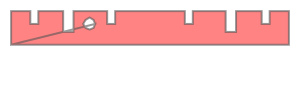

 0 130; 29 162; 245 113; 277 81; 192 0; 131 0; 0 130


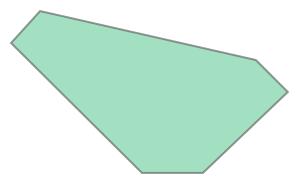

 129 50; 92 50; 92 46; 68 46; 68 50; 29 50; 29 50; 29 45; 29 45; 29 75; 28 76; 7 76; 7 75; 7 70; 7 70; 7 89; 6 89; 0 89; 0 89; 0 0; 0 0; 156 0; 156 0; 156 89; 156 89; 148 89; 147 89; 147 84; 147 84; 147 61; 147 61; 147 67; 130 67; 130 45; 130 45; 130 50; 129 50; 3 87; 3 88; 2 87; 3 87; 3 87


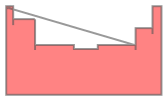

 202 0; 0 0; 0 40; 101 87; 202 40; 202 0; 34 27; 34 27; 202 0


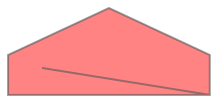

 201 0; 245 0; 245 44; 201 44; 192 35; 53 35; 44 44; 0 44; 0 0; 44 0; 53 9; 192 9; 201 0; 85 22; 84 26; 79 26; 76 24; 76 19; 79 17; 84 18; 85 21; 85 22


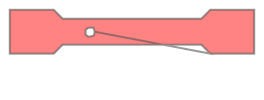

 199 158; 93 158; 66 132; 0 132; 0 13; 66 13; 93 0; 199 0; 212 13; 199 26; 106 26; 80 53; 80 105; 106 119; 199 119; 212 132; 199 158


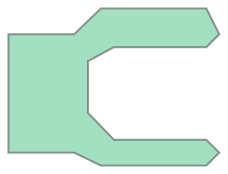

 170 154; 0 154; 0 154; 0 0; 0 0; 170 0; 170 0; 170 154; 170 154; 32 42; 32 112; 138 112; 138 42; 32 42


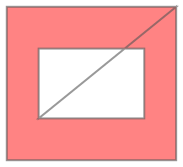

 0 0; 100 0; 100 0; 100 6; 100 6; 77 6; 77 72; 100 72; 100 72; 100 78; 100 78; 0 78; 0 78; 0 0; 0 0


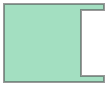

 10 34; 43 34; 46 37; 46 45; 48 48; 91 48; 93 45; 93 36; 96 33; 131 33; 133 36; 133 48; 150 65; 150 82; 152 85; 162 85; 163 84; 185 63; 185 35; 190 35; 195 30; 195 0; 0 0; 0 27; 2 27; 3 28; 3 39; 2 40; 0 40; 0 54; 13 54; 13 34; 10 34; 10 34; 54 40; 53 42; 51 41; 51 39; 53 38; 54 40


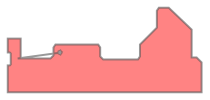

 0 4; 0 158; 4 158; 5 158; 5 162; 218 162; 218 158; 219 158; 225 158; 225 4; 219 4; 218 4; 218 0; 5 0; 5 4; 4 4; 0 4; 14 43; 14 119; 183 119; 183 43; 14 43


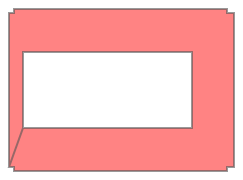

 166 112; 166 0; 0 0; 0 20; 9 30; 9 43; 66 43; 66 68; 9 68; 9 82; 0 92; 0 112; 166 112; 18 4; 5 4; 5 10; 18 10; 18 4


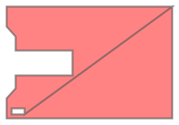

 14 8; 26 8; 27 7; 28 6; 28 6; 31 6; 31 6; 32 7; 32 8; 83 8; 84 8; 181 64; 182 65; 182 190; 182 190; 215 190; 216 190; 216 29; 215 29; 164 0; 164 0; 1 0; 0 0; 0 9; 1 9; 12 9; 12 9; 14 8; 14 8; 17 3; 16 4; 16 2; 17 3


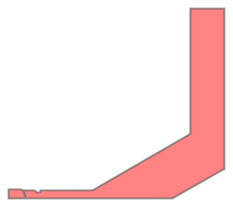

 43 65; 43 64; 42 64; 42 64; 39 64; 39 64; 38 64; 38 65; 2 65; 0 63; 0 2; 2 0; 102 0; 104 2; 104 63; 102 65; 43 65; 21 9; 19 12; 14 12; 12 9; 14 5; 19 5; 21 9


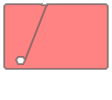

 78 14; 78 14; 77 14; 77 14; 77 15; 77 15; 78 15; 78 15; 78 27; 78 27; 72 33; 71 33; 11 33; 11 33; 11 36; 10 36; 1 36; 0 36; 0 15; 1 14; 10 14; 11 15; 11 17; 11 18; 63 18; 63 0; 78 0; 78 14; 27 27; 46 27; 46 24; 27 24; 27 27


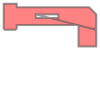

 191 68; 195 64; 195 16; 194 13; 177 1; 175 0; 46 0; 43 1; 1 33; 0 35; 0 64; 4 68; 191 68; 147 34; 147 37; 146 41; 145 44; 143 47; 141 49; 138 52; 135 53; 132 55; 129 55; 125 56; 121 55; 118 55; 115 53; 112 52; 110 49; 107 47; 105 44; 104 41; 103 37; 103 34; 103 30; 104 27; 105 24; 107 21; 110 18; 112 16; 115 14; 118 13; 121 12; 125 12; 129 12; 132 13; 135 14; 138 16; 141 18; 143 21; 145 24; 146 27; 147 30; 147 34


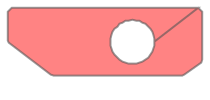

 2 35; 0 35; 0 33; 0 33; 0 0; 8 0; 8 4; 15 4; 15 0; 138 0; 138 24; 26 24; 26 50; 138 50; 138 76; 15 76; 15 72; 8 72; 8 76; 0 76; 0 41; 0 41; 0 40; 2 40; 2 35


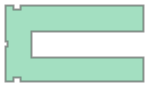

 178 54; 161 54; 161 53; 161 46; 140 46; 140 52; 140 53; 130 53; 130 52; 130 51; 120 51; 120 53; 120 54; 14 54; 1 40; 0 39; 0 1; 0 0; 202 0; 202 1; 202 53; 202 54; 187 54; 187 53; 187 52; 178 52; 178 53; 178 54; 18 7; 17 8; 14 8; 14 5; 17 5; 18 7


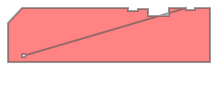

 0 74; 0 74; 0 73; 1 73; 1 68; 0 68; 0 66; 0 66; 0 3; 3 0; 96 0; 97 0; 159 62; 160 63; 160 139; 157 142; 146 142; 143 139; 143 98; 59 98; 59 139; 56 142; 3 142; 0 139; 0 74; 14 39; 34 39; 34 24; 14 24; 14 39


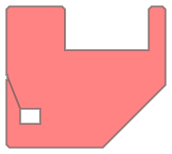

 122 136; 122 134; 120 134; 120 134; 116 134; 116 134; 114 134; 114 136; 57 136; 57 83; 32 83; 32 136; 0 136; 0 0; 215 38; 215 136; 204 136; 204 83; 179 83; 179 136; 122 136


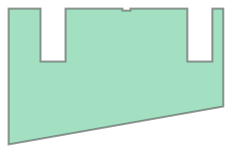

 46 43; 46 43; 45 42; 43 42; 41 43; 41 43; 41 43; 40 43; 40 59; 39 61; 4 63; 3 62; 0 2; 0 1; 35 0; 36 0; 38 16; 46 16; 181 16; 183 17; 183 23; 181 25; 134 25; 134 25; 97 42; 97 42; 96 43; 49 43; 46 43; 93 26; 90 26; 90 18; 93 18; 93 26


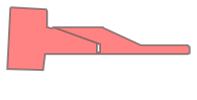

 33 0; 33 0; 35 0; 35 1; 40 1; 40 0; 41 0; 41 0; 76 0; 76 24; 61 24; 61 52; 46 67; 30 67; 15 52; 15 24; 0 24; 0 0; 33 0


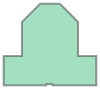

 265 3; 265 68; 262 71; 81 71; 78 74; 78 139; 75 142; 3 142; 0 139; 0 3; 3 0; 262 0; 265 3; 251 19; 237 19; 237 9; 251 9; 251 19


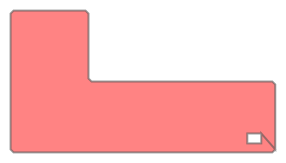

 12 102; 0 90; 0 3; 2 0; 43 0; 46 3; 46 49; 98 49; 98 3; 101 0; 142 0; 144 3; 144 90; 132 102; 12 102


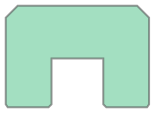

 137 61; 136 61; 136 62; 136 62; 136 66; 136 66; 136 68; 137 68; 137 127; 134 130; 3 130; 0 127; 0 82; 3 79; 7 79; 10 82; 10 94; 26 94; 26 3; 29 0; 108 0; 111 3; 111 14; 127 14; 127 3; 130 0; 134 0; 137 3; 137 61


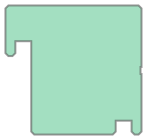

 100 0; 101 1; 101 15; 105 19; 132 19; 139 17; 142 16; 144 19; 139 23; 138 24; 138 30; 139 30; 144 34; 142 38; 139 37; 132 35; 105 35; 101 39; 101 53; 100 54; 28 54; 0 27; 28 0; 100 0


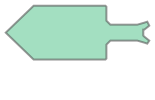

 114 103; 113 103; 21 103; 21 83; 22 83; 22 80; 20 80; 20 81; 0 81; 0 26; 20 26; 20 27; 22 27; 22 24; 21 24; 21 4; 113 4; 114 4; 144 16; 146 19; 146 27; 148 27; 148 4; 152 0; 180 0; 183 4; 183 81; 180 84; 152 84; 148 81; 148 80; 146 80; 146 88; 144 90; 114 103; 180 29; 179 33; 178 35; 175 37; 172 38; 169 38; 166 36; 164 34; 163 31; 162 27; 163 25; 165 22; 168 20; 172 20; 175 21; 177 23; 179 25; 180 29; 180 29


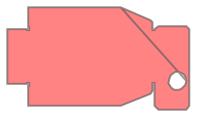

 108 105; 120 94; 120 93; 128 86; 85 2; 83 2; 79 13; 78 13; 78 14; 78 14; 78 12; 77 1; 76 0; 1 0; 1 0; 1 0; 0 0; 0 0; 0 0; 0 1; 0 1; 0 1; 0 1; 0 1; 4 13; 4 105; 5 106; 107 106; 108 105; 18 85; 18 83; 22 83; 22 85; 18 85


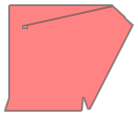

 154 2; 154 0; 157 0; 157 0; 300 0; 304 5; 304 72; 297 72; 297 36; 275 36; 275 72; 266 72; 266 36; 234 36; 234 72; 67 72; 67 36; 36 36; 36 72; 26 72; 26 36; 4 36; 4 72; 0 72; 0 5; 4 0; 145 0; 145 0; 147 0; 147 2; 154 2


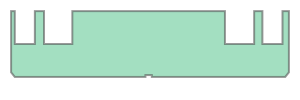

 73 27; 71 27; 71 31; 75 31; 75 29; 163 29; 163 31; 166 31; 166 27; 165 27; 165 0; 184 0; 187 3; 187 29; 189 32; 197 32; 199 29; 199 3; 202 0; 233 0; 238 5; 238 45; 238 48; 201 110; 196 113; 44 113; 38 109; 22 51; 17 47; 5 47; 0 41; 0 5; 5 0; 73 0; 73 27; 163 44; 163 84; 191 84; 197 78; 197 50; 191 44; 163 44


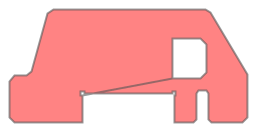

 0 0; 154 0; 154 154; 0 154; 0 0; 88 88; 86 92; 83 97; 78 99; 73 99; 69 96; 66 91; 66 86; 68 81; 72 78; 77 77; 81 78; 85 81; 87 86; 88 88


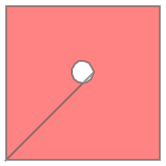

 159 49; 167 44; 168 44; 308 44; 308 2; 310 0; 359 0; 361 2; 361 17; 374 17; 376 20; 376 72; 374 74; 361 74; 361 90; 359 92; 17 92; 17 76; 17 76; 17 74; 16 74; 16 75; 0 75; 0 14; 2 12; 25 12; 27 14; 27 44; 50 44; 51 44; 59 49; 159 49; 29 65; 29 66; 28 66; 27 66; 26 66; 25 65; 26 64; 27 63; 28 63; 29 64; 29 65


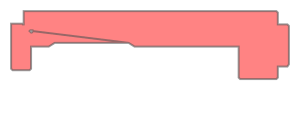

 165 64; 165 31; 162 31; 162 64; 0 64; 0 33; 1 33; 1 0; 315 0; 321 6; 321 88; 315 94; 263 94; 261 91; 261 66; 259 64; 165 64


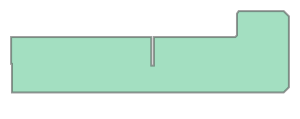

 0 140; 0 0; 180 0; 180 140; 126 140; 126 147; 54 147; 54 140; 0 140; 104 104; 94 118; 76 115; 76 97; 94 90; 104 104


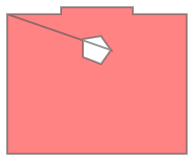

 532 10; 531 12; 412 47; 411 48; 171 48; 170 49; 170 69; 169 70; 130 70; 124 64; 124 34; 122 34; 122 70; 119 70; 0 22; 0 7; 1 6; 15 6; 16 4; 16 1; 17 0; 366 0; 368 1; 368 4; 369 6; 384 6; 386 4; 386 1; 387 0; 399 0; 399 24; 403 24; 403 0; 532 0; 532 10; 22 16; 21 18; 19 20; 16 19; 13 17; 13 14; 16 12; 19 11; 21 13; 22 16


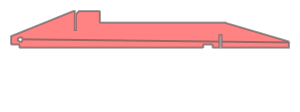

 95 93; 95 91; 13 91; 12 90; 12 83; 11 82; 1 82; 0 83; 0 141; 1 142; 289 142; 290 141; 290 83; 289 82; 279 82; 278 83; 278 90; 277 91; 195 91; 195 93; 192 93; 192 90; 194 90; 194 1; 192 0; 98 0; 96 1; 96 90; 98 90; 98 93; 95 93; 109 7; 109 10; 105 10; 105 7; 109 7


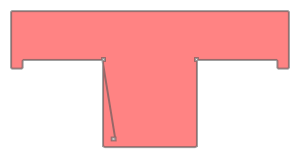

 184 63; 158 37; 158 37; 158 30; 151 30; 151 37; 124 63; 1 63; 0 62; 0 38; 1 37; 33 37; 33 1; 34 0; 287 0; 288 1; 288 46; 287 47; 184 63; 184 63; 246 6; 245 8; 241 8; 241 4; 245 4; 246 6


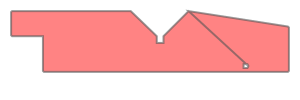

 0 209; 0 209; 0 208; 1 208; 1 205; 0 205; 0 204; 0 204; 0 2; 2 0; 293 0; 295 2; 295 40; 293 42; 44 42; 42 44; 42 230; 39 232; 2 232; 0 230; 0 209; 37 33; 34 37; 30 35; 30 31; 34 29; 37 33


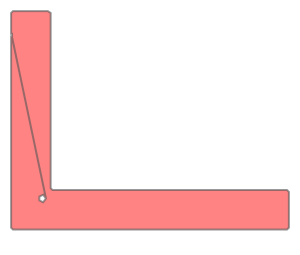

 1 81; 0 81; 0 81; 0 81; 0 56; 4 53; 85 53; 88 50; 97 37; 100 35; 117 35; 120 33; 142 1; 145 0; 170 0; 174 3; 174 163; 170 166; 145 166; 142 164; 120 132; 117 131; 100 131; 97 128; 88 115; 85 113; 4 113; 0 110; 0 85; 0 85; 0 84; 1 84; 1 81; 11 60; 9 63; 5 63; 3 60; 5 56; 9 56; 11 60


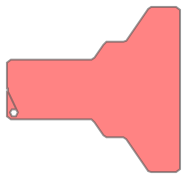

 29 18; 29 10; 26 7; 7 7; 4 10; 4 18; 1 21; 0 21; 0 17; 0 17; 0 15; 0 15; 0 7; 0 7; 0 6; 0 6; 0 0; 8 0; 8 0; 10 0; 10 0; 34 0; 34 0; 35 0; 35 0; 60 0; 60 0; 61 0; 61 0; 86 0; 86 0; 87 0; 87 0; 112 0; 112 0; 113 0; 113 0; 121 0; 121 21; 33 21; 29 18; 61 15; 61 15; 61 17; 61 17; 61 15


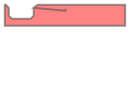

 20 138; 20 138; 20 138; 19 138; 17 138; 17 138; 17 138; 16 138; 0 138; 0 18; 17 18; 17 19; 20 19; 20 16; 18 16; 18 0; 51 0; 54 2; 54 5; 56 8; 176 8; 176 18; 183 24; 183 40; 33 138; 20 138; 37 45; 37 96; 49 103; 129 51; 124 36; 45 36; 37 45


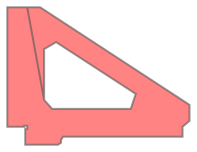

 101 16; 101 20; 100 20; 50 20; 50 20; 40 30; 40 30; 40 106; 40 106; 50 116; 50 116; 100 116; 101 116; 101 120; 101 120; 118 120; 118 120; 118 135; 118 136; 6 136; 6 129; 7 129; 7 129; 6 129; 6 129; 0 129; 0 7; 6 7; 6 7; 7 7; 7 7; 6 7; 6 0; 118 0; 118 1; 118 16; 118 16; 101 16; 101 16; 4 37; 3 38; 2 38; 2 37; 3 36; 4 37


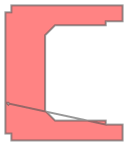

 3 0; 21 0; 24 3; 24 11; 33 20; 77 20; 85 11; 85 3; 88 0; 217 0; 217 29; 214 29; 214 35; 221 35; 221 32; 250 32; 250 84; 247 87; 98 87; 95 86; 66 56; 64 56; 3 56; 0 53; 0 3; 3 0; 15 5; 9 5; 9 9; 15 9; 15 5


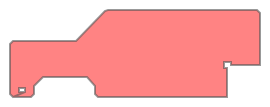

 105 113; 92 113; 90 112; 90 43; 90 42; 90 41; 65 17; 64 16; 1 16; 0 15; 0 1; 1 0; 196 0; 197 1; 197 15; 196 16; 133 16; 132 17; 107 41; 107 42; 107 43; 107 112; 105 113; 10 8; 9 10; 8 11; 6 11; 4 11; 3 10; 3 8; 3 6; 4 5; 6 4; 8 5; 9 6; 10 8


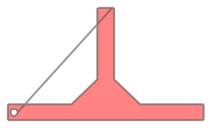

 78 0; 79 1; 79 19; 78 20; 68 20; 68 19; 68 13; 67 12; 52 12; 52 13; 52 34; 51 34; 45 34; 45 35; 45 49; 44 50; 41 50; 41 49; 41 42; 40 42; 1 42; 0 41; 0 1; 1 0; 78 0; 4 4; 3 5; 2 4; 3 3; 4 4


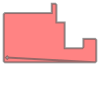

 30 51; 32 49; 195 49; 197 51; 197 71; 202 71; 202 15; 188 15; 188 14; 182 13; 181 11; 181 3; 183 0; 225 0; 227 3; 227 154; 225 156; 174 188; 170 194; 170 220; 168 223; 123 223; 121 220; 121 188; 122 187; 201 138; 202 137; 202 131; 25 131; 25 137; 26 138; 105 187; 106 188; 106 220; 104 223; 59 223; 57 220; 57 194; 53 188; 1 156; 0 154; 0 3; 2 0; 44 0; 46 3; 46 11; 44 13; 39 14; 38 15; 25 15; 25 71; 30 71; 30 51; 39 89; 39 113; 46 120; 180 120; 187 113; 187 89; 180 82; 46 82; 39 89


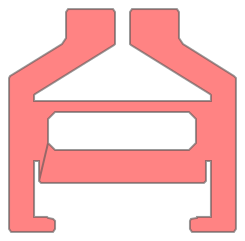

 130 49; 130 49; 130 50; 130 50; 130 53; 130 53; 130 53; 130 53; 130 62; 0 62; 0 0; 80 0; 82 1; 82 41; 130 41; 130 49; 13 12; 10 15; 6 16; 3 14; 3 9; 6 7; 10 8; 12 11; 13 12


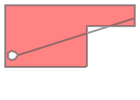

 0 35; 5 1; 6 0; 6 0; 7 1; 7 2; 7 3; 7 3; 7 2; 7 1; 8 0; 38 0; 38 1; 38 2; 38 3; 38 3; 39 2; 39 1; 39 0; 42 0; 43 1; 43 19; 42 20; 41 21; 41 21; 41 21; 41 22; 41 23; 40 24; 9 39; 8 39; 7 38; 6 38; 6 37; 5 38; 3 36; 3 36; 3 36; 2 36; 2 36; 2 35; 2 35; 1 35; 1 36; 1 36; 0 35


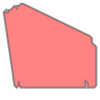

 150 128; 149 128; 149 92; 149 91; 127 70; 127 70; 34 70; 33 69; 33 28; 32 27; 1 27; 0 26; 0 0; 1 0; 193 0; 194 0; 194 27; 195 28; 231 28; 232 29; 232 64; 231 64; 168 64; 167 65; 167 128; 166 128; 150 128; 42 36; 41 38; 39 38; 38 36; 39 34; 41 34; 42 36


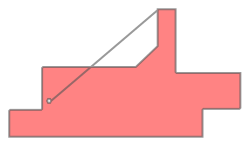

In [5]:

neu_figure = "[ 0 0; 347 0; 347 42; 323 42; 323 26; 313 26; 313 42; 281 42; 281 16; 268 16; 268 42; 227 42; 227 26; 217 26; 217 42; 130 42; 130 26; 120 26; 120 42; 78 42; 78 16; 65 16; 65 42; 34 42; 34 26; 24 26; 24 42; 0 42; 0 0; 105 26; 103 31; 98 34; 93 31; 90 26; 93 21; 98 19; 103 21; 105 26][ 0 130; 29 162; 245 113; 277 81; 192 0; 131 0; 0 130][ 129 50; 92 50; 92 46; 68 46; 68 50; 29 50; 29 50; 29 45; 29 45; 29 75; 28 76; 7 76; 7 75; 7 70; 7 70; 7 89; 6 89; 0 89; 0 89; 0 0; 0 0; 156 0; 156 0; 156 89; 156 89; 148 89; 147 89; 147 84; 147 84; 147 61; 147 61; 147 67; 130 67; 130 45; 130 45; 130 50; 129 50; 3 87; 3 88; 2 87; 3 87; 3 87][ 202 0; 0 0; 0 40; 101 87; 202 40; 202 0; 34 27; 34 27; 202 0][ 201 0; 245 0; 245 44; 201 44; 192 35; 53 35; 44 44; 0 44; 0 0; 44 0; 53 9; 192 9; 201 0; 85 22; 84 26; 79 26; 76 24; 76 19; 79 17; 84 18; 85 21; 85 22][ 199 158; 93 158; 66 132; 0 132; 0 13; 66 13; 93 0; 199 0; 212 13; 199 26; 106 26; 80 53; 80 105; 106 119; 199 119; 212 132; 199 158][ 170 154; 0 154; 0 154; 0 0; 0 0; 170 0; 170 0; 170 154; 170 154; 32 42; 32 112; 138 112; 138 42; 32 42][ 0 0; 100 0; 100 0; 100 6; 100 6; 77 6; 77 72; 100 72; 100 72; 100 78; 100 78; 0 78; 0 78; 0 0; 0 0][ 10 34; 43 34; 46 37; 46 45; 48 48; 91 48; 93 45; 93 36; 96 33; 131 33; 133 36; 133 48; 150 65; 150 82; 152 85; 162 85; 163 84; 185 63; 185 35; 190 35; 195 30; 195 0; 0 0; 0 27; 2 27; 3 28; 3 39; 2 40; 0 40; 0 54; 13 54; 13 34; 10 34; 10 34; 54 40; 53 42; 51 41; 51 39; 53 38; 54 40][ 0 4; 0 158; 4 158; 5 158; 5 162; 218 162; 218 158; 219 158; 225 158; 225 4; 219 4; 218 4; 218 0; 5 0; 5 4; 4 4; 0 4; 14 43; 14 119; 183 119; 183 43; 14 43][ 166 112; 166 0; 0 0; 0 20; 9 30; 9 43; 66 43; 66 68; 9 68; 9 82; 0 92; 0 112; 166 112; 18 4; 5 4; 5 10; 18 10; 18 4][ 14 8; 26 8; 27 7; 28 6; 28 6; 31 6; 31 6; 32 7; 32 8; 83 8; 84 8; 181 64; 182 65; 182 190; 182 190; 215 190; 216 190; 216 29; 215 29; 164 0; 164 0; 1 0; 0 0; 0 9; 1 9; 12 9; 12 9; 14 8; 14 8; 17 3; 16 4; 16 2; 17 3][ 43 65; 43 64; 42 64; 42 64; 39 64; 39 64; 38 64; 38 65; 2 65; 0 63; 0 2; 2 0; 102 0; 104 2; 104 63; 102 65; 43 65; 21 9; 19 12; 14 12; 12 9; 14 5; 19 5; 21 9][ 78 14; 78 14; 77 14; 77 14; 77 15; 77 15; 78 15; 78 15; 78 27; 78 27; 72 33; 71 33; 11 33; 11 33; 11 36; 10 36; 1 36; 0 36; 0 15; 1 14; 10 14; 11 15; 11 17; 11 18; 63 18; 63 0; 78 0; 78 14; 27 27; 46 27; 46 24; 27 24; 27 27][ 191 68; 195 64; 195 16; 194 13; 177 1; 175 0; 46 0; 43 1; 1 33; 0 35; 0 64; 4 68; 191 68; 147 34; 147 37; 146 41; 145 44; 143 47; 141 49; 138 52; 135 53; 132 55; 129 55; 125 56; 121 55; 118 55; 115 53; 112 52; 110 49; 107 47; 105 44; 104 41; 103 37; 103 34; 103 30; 104 27; 105 24; 107 21; 110 18; 112 16; 115 14; 118 13; 121 12; 125 12; 129 12; 132 13; 135 14; 138 16; 141 18; 143 21; 145 24; 146 27; 147 30; 147 34][ 2 35; 0 35; 0 33; 0 33; 0 0; 8 0; 8 4; 15 4; 15 0; 138 0; 138 24; 26 24; 26 50; 138 50; 138 76; 15 76; 15 72; 8 72; 8 76; 0 76; 0 41; 0 41; 0 40; 2 40; 2 35][ 178 54; 161 54; 161 53; 161 46; 140 46; 140 52; 140 53; 130 53; 130 52; 130 51; 120 51; 120 53; 120 54; 14 54; 1 40; 0 39; 0 1; 0 0; 202 0; 202 1; 202 53; 202 54; 187 54; 187 53; 187 52; 178 52; 178 53; 178 54; 18 7; 17 8; 14 8; 14 5; 17 5; 18 7][ 0 74; 0 74; 0 73; 1 73; 1 68; 0 68; 0 66; 0 66; 0 3; 3 0; 96 0; 97 0; 159 62; 160 63; 160 139; 157 142; 146 142; 143 139; 143 98; 59 98; 59 139; 56 142; 3 142; 0 139; 0 74; 14 39; 34 39; 34 24; 14 24; 14 39][ 122 136; 122 134; 120 134; 120 134; 116 134; 116 134; 114 134; 114 136; 57 136; 57 83; 32 83; 32 136; 0 136; 0 0; 215 38; 215 136; 204 136; 204 83; 179 83; 179 136; 122 136][ 46 43; 46 43; 45 42; 43 42; 41 43; 41 43; 41 43; 40 43; 40 59; 39 61; 4 63; 3 62; 0 2; 0 1; 35 0; 36 0; 38 16; 46 16; 181 16; 183 17; 183 23; 181 25; 134 25; 134 25; 97 42; 97 42; 96 43; 49 43; 46 43; 93 26; 90 26; 90 18; 93 18; 93 26][ 33 0; 33 0; 35 0; 35 1; 40 1; 40 0; 41 0; 41 0; 76 0; 76 24; 61 24; 61 52; 46 67; 30 67; 15 52; 15 24; 0 24; 0 0; 33 0][ 265 3; 265 68; 262 71; 81 71; 78 74; 78 139; 75 142; 3 142; 0 139; 0 3; 3 0; 262 0; 265 3; 251 19; 237 19; 237 9; 251 9; 251 19][ 12 102; 0 90; 0 3; 2 0; 43 0; 46 3; 46 49; 98 49; 98 3; 101 0; 142 0; 144 3; 144 90; 132 102; 12 102][ 137 61; 136 61; 136 62; 136 62; 136 66; 136 66; 136 68; 137 68; 137 127; 134 130; 3 130; 0 127; 0 82; 3 79; 7 79; 10 82; 10 94; 26 94; 26 3; 29 0; 108 0; 111 3; 111 14; 127 14; 127 3; 130 0; 134 0; 137 3; 137 61][ 100 0; 101 1; 101 15; 105 19; 132 19; 139 17; 142 16; 144 19; 139 23; 138 24; 138 30; 139 30; 144 34; 142 38; 139 37; 132 35; 105 35; 101 39; 101 53; 100 54; 28 54; 0 27; 28 0; 100 0][ 114 103; 113 103; 21 103; 21 83; 22 83; 22 80; 20 80; 20 81; 0 81; 0 26; 20 26; 20 27; 22 27; 22 24; 21 24; 21 4; 113 4; 114 4; 144 16; 146 19; 146 27; 148 27; 148 4; 152 0; 180 0; 183 4; 183 81; 180 84; 152 84; 148 81; 148 80; 146 80; 146 88; 144 90; 114 103; 180 29; 179 33; 178 35; 175 37; 172 38; 169 38; 166 36; 164 34; 163 31; 162 27; 163 25; 165 22; 168 20; 172 20; 175 21; 177 23; 179 25; 180 29; 180 29][ 108 105; 120 94; 120 93; 128 86; 85 2; 83 2; 79 13; 78 13; 78 14; 78 14; 78 12; 77 1; 76 0; 1 0; 1 0; 1 0; 0 0; 0 0; 0 0; 0 1; 0 1; 0 1; 0 1; 0 1; 4 13; 4 105; 5 106; 107 106; 108 105; 18 85; 18 83; 22 83; 22 85; 18 85][ 154 2; 154 0; 157 0; 157 0; 300 0; 304 5; 304 72; 297 72; 297 36; 275 36; 275 72; 266 72; 266 36; 234 36; 234 72; 67 72; 67 36; 36 36; 36 72; 26 72; 26 36; 4 36; 4 72; 0 72; 0 5; 4 0; 145 0; 145 0; 147 0; 147 2; 154 2][ 73 27; 71 27; 71 31; 75 31; 75 29; 163 29; 163 31; 166 31; 166 27; 165 27; 165 0; 184 0; 187 3; 187 29; 189 32; 197 32; 199 29; 199 3; 202 0; 233 0; 238 5; 238 45; 238 48; 201 110; 196 113; 44 113; 38 109; 22 51; 17 47; 5 47; 0 41; 0 5; 5 0; 73 0; 73 27; 163 44; 163 84; 191 84; 197 78; 197 50; 191 44; 163 44][ 0 0; 154 0; 154 154; 0 154; 0 0; 88 88; 86 92; 83 97; 78 99; 73 99; 69 96; 66 91; 66 86; 68 81; 72 78; 77 77; 81 78; 85 81; 87 86; 88 88][ 159 49; 167 44; 168 44; 308 44; 308 2; 310 0; 359 0; 361 2; 361 17; 374 17; 376 20; 376 72; 374 74; 361 74; 361 90; 359 92; 17 92; 17 76; 17 76; 17 74; 16 74; 16 75; 0 75; 0 14; 2 12; 25 12; 27 14; 27 44; 50 44; 51 44; 59 49; 159 49; 29 65; 29 66; 28 66; 27 66; 26 66; 25 65; 26 64; 27 63; 28 63; 29 64; 29 65][ 165 64; 165 31; 162 31; 162 64; 0 64; 0 33; 1 33; 1 0; 315 0; 321 6; 321 88; 315 94; 263 94; 261 91; 261 66; 259 64; 165 64][ 0 140; 0 0; 180 0; 180 140; 126 140; 126 147; 54 147; 54 140; 0 140; 104 104; 94 118; 76 115; 76 97; 94 90; 104 104][ 532 10; 531 12; 412 47; 411 48; 171 48; 170 49; 170 69; 169 70; 130 70; 124 64; 124 34; 122 34; 122 70; 119 70; 0 22; 0 7; 1 6; 15 6; 16 4; 16 1; 17 0; 366 0; 368 1; 368 4; 369 6; 384 6; 386 4; 386 1; 387 0; 399 0; 399 24; 403 24; 403 0; 532 0; 532 10; 22 16; 21 18; 19 20; 16 19; 13 17; 13 14; 16 12; 19 11; 21 13; 22 16][ 95 93; 95 91; 13 91; 12 90; 12 83; 11 82; 1 82; 0 83; 0 141; 1 142; 289 142; 290 141; 290 83; 289 82; 279 82; 278 83; 278 90; 277 91; 195 91; 195 93; 192 93; 192 90; 194 90; 194 1; 192 0; 98 0; 96 1; 96 90; 98 90; 98 93; 95 93; 109 7; 109 10; 105 10; 105 7; 109 7][ 184 63; 158 37; 158 37; 158 30; 151 30; 151 37; 124 63; 1 63; 0 62; 0 38; 1 37; 33 37; 33 1; 34 0; 287 0; 288 1; 288 46; 287 47; 184 63; 184 63; 246 6; 245 8; 241 8; 241 4; 245 4; 246 6][ 0 209; 0 209; 0 208; 1 208; 1 205; 0 205; 0 204; 0 204; 0 2; 2 0; 293 0; 295 2; 295 40; 293 42; 44 42; 42 44; 42 230; 39 232; 2 232; 0 230; 0 209; 37 33; 34 37; 30 35; 30 31; 34 29; 37 33][ 1 81; 0 81; 0 81; 0 81; 0 56; 4 53; 85 53; 88 50; 97 37; 100 35; 117 35; 120 33; 142 1; 145 0; 170 0; 174 3; 174 163; 170 166; 145 166; 142 164; 120 132; 117 131; 100 131; 97 128; 88 115; 85 113; 4 113; 0 110; 0 85; 0 85; 0 84; 1 84; 1 81; 11 60; 9 63; 5 63; 3 60; 5 56; 9 56; 11 60][ 29 18; 29 10; 26 7; 7 7; 4 10; 4 18; 1 21; 0 21; 0 17; 0 17; 0 15; 0 15; 0 7; 0 7; 0 6; 0 6; 0 0; 8 0; 8 0; 10 0; 10 0; 34 0; 34 0; 35 0; 35 0; 60 0; 60 0; 61 0; 61 0; 86 0; 86 0; 87 0; 87 0; 112 0; 112 0; 113 0; 113 0; 121 0; 121 21; 33 21; 29 18; 61 15; 61 15; 61 17; 61 17; 61 15][ 20 138; 20 138; 20 138; 19 138; 17 138; 17 138; 17 138; 16 138; 0 138; 0 18; 17 18; 17 19; 20 19; 20 16; 18 16; 18 0; 51 0; 54 2; 54 5; 56 8; 176 8; 176 18; 183 24; 183 40; 33 138; 20 138; 37 45; 37 96; 49 103; 129 51; 124 36; 45 36; 37 45][ 101 16; 101 20; 100 20; 50 20; 50 20; 40 30; 40 30; 40 106; 40 106; 50 116; 50 116; 100 116; 101 116; 101 120; 101 120; 118 120; 118 120; 118 135; 118 136; 6 136; 6 129; 7 129; 7 129; 6 129; 6 129; 0 129; 0 7; 6 7; 6 7; 7 7; 7 7; 6 7; 6 0; 118 0; 118 1; 118 16; 118 16; 101 16; 101 16; 4 37; 3 38; 2 38; 2 37; 3 36; 4 37][ 3 0; 21 0; 24 3; 24 11; 33 20; 77 20; 85 11; 85 3; 88 0; 217 0; 217 29; 214 29; 214 35; 221 35; 221 32; 250 32; 250 84; 247 87; 98 87; 95 86; 66 56; 64 56; 3 56; 0 53; 0 3; 3 0; 15 5; 9 5; 9 9; 15 9; 15 5][ 105 113; 92 113; 90 112; 90 43; 90 42; 90 41; 65 17; 64 16; 1 16; 0 15; 0 1; 1 0; 196 0; 197 1; 197 15; 196 16; 133 16; 132 17; 107 41; 107 42; 107 43; 107 112; 105 113; 10 8; 9 10; 8 11; 6 11; 4 11; 3 10; 3 8; 3 6; 4 5; 6 4; 8 5; 9 6; 10 8][ 78 0; 79 1; 79 19; 78 20; 68 20; 68 19; 68 13; 67 12; 52 12; 52 13; 52 34; 51 34; 45 34; 45 35; 45 49; 44 50; 41 50; 41 49; 41 42; 40 42; 1 42; 0 41; 0 1; 1 0; 78 0; 4 4; 3 5; 2 4; 3 3; 4 4][ 30 51; 32 49; 195 49; 197 51; 197 71; 202 71; 202 15; 188 15; 188 14; 182 13; 181 11; 181 3; 183 0; 225 0; 227 3; 227 154; 225 156; 174 188; 170 194; 170 220; 168 223; 123 223; 121 220; 121 188; 122 187; 201 138; 202 137; 202 131; 25 131; 25 137; 26 138; 105 187; 106 188; 106 220; 104 223; 59 223; 57 220; 57 194; 53 188; 1 156; 0 154; 0 3; 2 0; 44 0; 46 3; 46 11; 44 13; 39 14; 38 15; 25 15; 25 71; 30 71; 30 51; 39 89; 39 113; 46 120; 180 120; 187 113; 187 89; 180 82; 46 82; 39 89][ 130 49; 130 49; 130 50; 130 50; 130 53; 130 53; 130 53; 130 53; 130 62; 0 62; 0 0; 80 0; 82 1; 82 41; 130 41; 130 49; 13 12; 10 15; 6 16; 3 14; 3 9; 6 7; 10 8; 12 11; 13 12][ 0 35; 5 1; 6 0; 6 0; 7 1; 7 2; 7 3; 7 3; 7 2; 7 1; 8 0; 38 0; 38 1; 38 2; 38 3; 38 3; 39 2; 39 1; 39 0; 42 0; 43 1; 43 19; 42 20; 41 21; 41 21; 41 21; 41 22; 41 23; 40 24; 9 39; 8 39; 7 38; 6 38; 6 37; 5 38; 3 36; 3 36; 3 36; 2 36; 2 36; 2 35; 2 35; 1 35; 1 36; 1 36; 0 35][ 150 128; 149 128; 149 92; 149 91; 127 70; 127 70; 34 70; 33 69; 33 28; 32 27; 1 27; 0 26; 0 0; 1 0; 193 0; 194 0; 194 27; 195 28; 231 28; 232 29; 232 64; 231 64; 168 64; 167 65; 167 128; 166 128; 150 128; 42 36; 41 38; 39 38; 38 36; 39 34; 41 34; 42 36]"
temp = neu_figure[2:-1]
for i in temp.split("]["):
    print(i)
    b = i.split(";")
    c = [l.strip() for l in b]
    x = [float(l.split(" ")[0]) for l in c if l != "NaN NaN"]
    y = [float(l.split(" ")[1]) for l in c if l != "NaN NaN"]
    points = zip(x,y)
    polygon = Polygon(points)
    #polygon_list.append(polygon)
    polygon
    #print(polygon.area)

In [80]:
keep_cat_features = True
model_names = ["LGBMRegressor"]
for model_name in model_names:
    keep_cat_features = keep_cat_features and model_name in ['LGBMRegressor', 'LGBMClassifier', 'CatBoostRegressor', 'CatBoostClassifier']

In [82]:
if model_name[:12] == 'DeepLearning':
    print("")

In [83]:
import evolutionary_search

ModuleNotFoundError: No module named 'evolutionary_search'